# Sleap Feature Analysis

UMAP and clustering

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

from umap import UMAP
import math
%matplotlib inline

# Dimension reduction and clustering libraries
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [2]:
manual_scoring_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_csvs"

In [3]:
# df = pd.read_csv(r"C:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\home_cage_pose_DA_all.csv")

# df = pd.read_csv(r"C:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\HC_pose_investigation_only.csv")

# df = pd.read_csv(r"C:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\HC_pose_behaviors_only.csv")

# df = pd.read_csv(r"C:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\HC_automated_social_behaviors.csv")

df = pd.read_csv(r"C:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\HC_automated_only_social.csv\social_combined.csv")

c:\Users\alber\anaconda3\envs\photometry\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


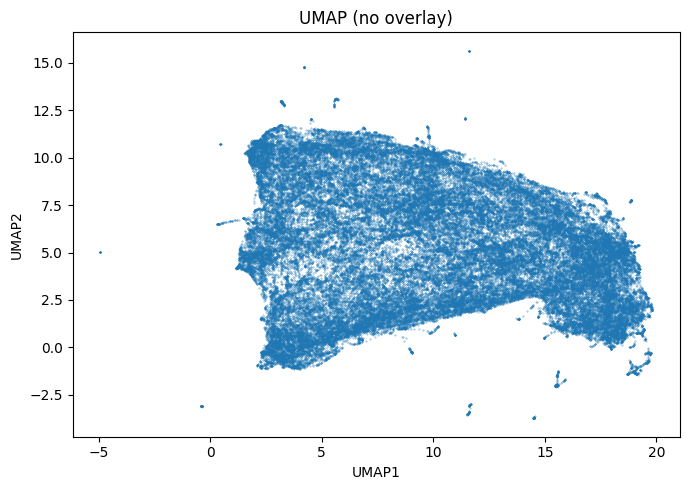

In [4]:
features = [
    "distance_head_res__head_int",
    "angle_head_res__head_int_deg",

    "distance_head_res__hind_int",
    "angle_head_res__hind_int_deg",

    "distance_head_int__hind_res",
    "angle_head_int__hind_res_deg",

    "distance_hind_res__hind_int",

    "velocity_resident",
    "velocity_intruder",
]

# ------------------ 2. Scale ------------------
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(X_scaled, columns=[f"{f}_scaled" for f in features], index=df.index)

# ------------------ 3. UMAP ------------------
embedding = UMAP(random_state=42).fit_transform(X_scaled)
df["umap1"], df["umap2"] = embedding[:, 0], embedding[:, 1]

df_all = pd.concat([df, df_scaled], axis=1)   # raw + scaled + umap1/2


# ------------------ 4a. Plain scatter (no colors) ------------------
plt.figure(figsize=(7,5))
plt.scatter(df["umap1"], df["umap2"], s=0.1, alpha=0.7)
plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.title("UMAP (no overlay)")
plt.tight_layout()
plt.show()


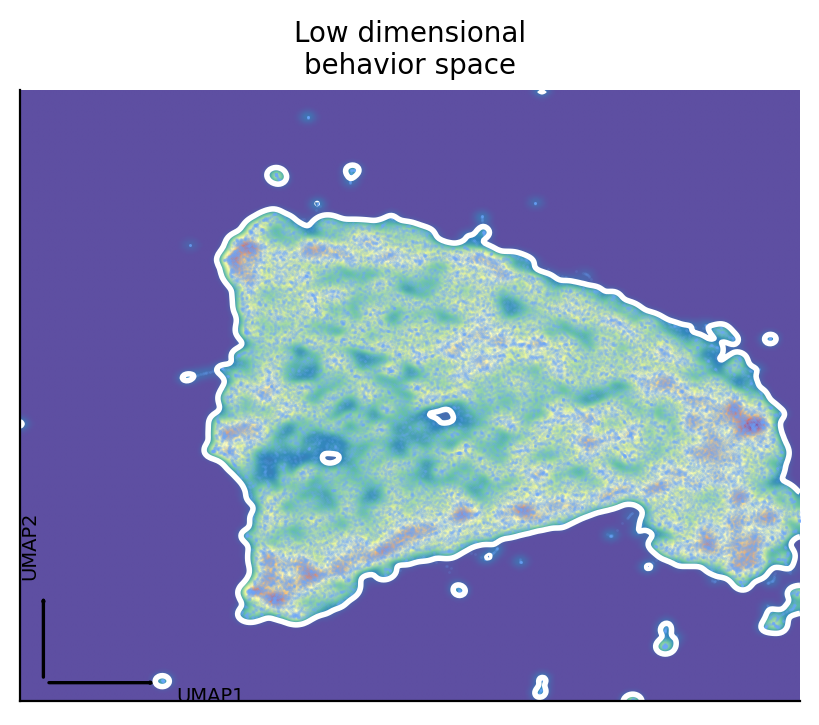

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import FancyArrowPatch

def umap_waterpaint(df, xcol="umap1", ycol="umap2",
                    bins=400, sigma=3,
                    cmap="Spectral_r",            # red hot, blue/cyan cool
                    dot_color="#6da8ff", dot_alpha=0.15, dot_size=1.0,
                    outline_pct=65,
                    title="Low dimensional\nbehavior space"):
    x = df[xcol].values
    y = df[ycol].values

    # 2D histogram → smooth
    H, xe, ye = np.histogram2d(x, y, bins=bins)
    H = gaussian_filter(H, sigma=sigma)
    H = H.T  # for imshow

    extent = [xe[0], xe[-1], ye[0], ye[-1]]

    fig, ax = plt.subplots(figsize=(4.2, 4.2), dpi=200)

    # background scatter of all frames
    ax.scatter(x, y, s=dot_size, c=dot_color, alpha=dot_alpha, linewidths=0)

    # heatmap
    im = ax.imshow(H, extent=extent, origin="lower",
                   cmap=cmap, interpolation="bilinear")

    # single global outline
    lvl = np.nanpercentile(H, outline_pct)
    ax.contour(np.linspace(extent[0], extent[1], H.shape[1]),
               np.linspace(extent[2], extent[3], H.shape[0]),
               H, levels=[lvl], colors="white", linewidths=2)

    # clean look
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(title, fontsize=10)

    # tiny axis arrows like the example
    xmin, xmax, ymin, ymax = extent
    ax.add_patch(FancyArrowPatch((xmin+0.03*(xmax-xmin), ymin+0.03*(ymax-ymin)),
                                 (xmin+0.18*(xmax-xmin), ymin+0.03*(ymax-ymin)),
                                 arrowstyle='-|>', lw=1.2, color='k'))
    ax.add_patch(FancyArrowPatch((xmin+0.03*(xmax-xmin), ymin+0.03*(ymax-ymin)),
                                 (xmin+0.03*(xmax-xmin), ymin+0.18*(ymax-ymin)),
                                 arrowstyle='-|>', lw=1.2, color='k'))
    ax.text(xmin+0.20*(xmax-xmin), ymin+0.00*(ymax-ymin), "UMAP1", fontsize=7)
    ax.text(xmin+0.00*(xmax-xmin), ymin+0.20*(ymax-ymin), "UMAP2", fontsize=7, rotation=90,
            va='bottom')

    plt.tight_layout()
    plt.show()

# call it
umap_waterpaint(df)


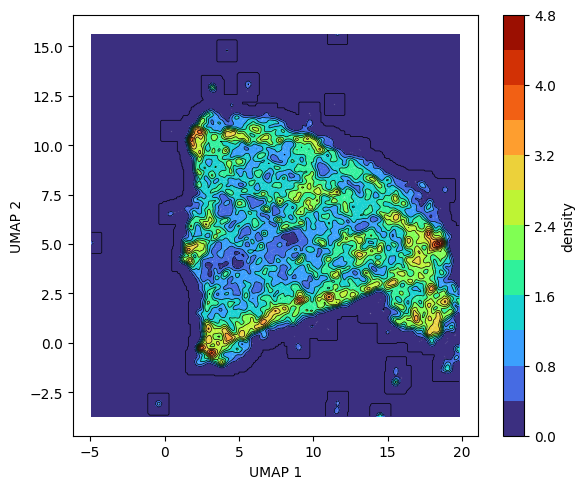

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def umap_topo(df, xcol="umap1", ycol="umap2",
              bins=400, sigma=2.5,
              levels=12, cmap="turbo",
              point_alpha=0.1, point_step=5):
    x = df[xcol].values
    y = df[ycol].values

    # 1) 2‑D histogram → smooth
    H, xe, ye = np.histogram2d(x, y, bins=bins)
    H = gaussian_filter(H, sigma=sigma)
    H = H.T                              # for imshow/contour

    # grid extents
    extent = [xe[0], xe[-1], ye[0], ye[-1]]

    fig, ax = plt.subplots(figsize=(6,5))

    # 2a) filled contours (topo look)
    cs = ax.contourf(H, levels=levels, cmap=cmap, extent=extent, origin="lower")

    # 2b) optional contour lines
    ax.contour(H, levels=levels, colors='k', linewidths=0.5, extent=extent, origin="lower")

    # 3) raw points on top (subsample & transparent)
    ax.scatter(x[::point_step], y[::point_step],
               s=1, c="white", alpha=point_alpha, linewidths=0)

    ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")
    cbar = fig.colorbar(cs, ax=ax, label="density")
    plt.tight_layout()
    plt.show()

umap_topo(df_all)   # df_all has umap1/umap2


In [7]:
df_all.columns

Index(['time_s', 'brain_region', 'mouse_identity', 'zscore_DA',
       'intruder_identity', 'agent_in_subject', 'subject_in_agent',
       'distance_head_res__head_int', 'angle_head_res__head_int_deg',
       'distance_head_res__hind_int', 'angle_head_res__hind_int_deg',
       'distance_head_int__hind_res', 'angle_head_int__hind_res_deg',
       'distance_hind_res__hind_int', 'velocity_resident', 'velocity_intruder',
       'behavior_active', 'umap1', 'umap2',
       'distance_head_res__head_int_scaled',
       'angle_head_res__head_int_deg_scaled',
       'distance_head_res__hind_int_scaled',
       'angle_head_res__hind_int_deg_scaled',
       'distance_head_int__hind_res_scaled',
       'angle_head_int__hind_res_deg_scaled',
       'distance_hind_res__hind_int_scaled', 'velocity_resident_scaled',
       'velocity_intruder_scaled'],
      dtype='object')

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_grid(df_umap,
                      feats,
                      vals="scaled",                # "scaled" or "raw"
                      scaled_suffix="_scaled",
                      ncols=3,
                      cmap="Blues",
                      vlim=(-1, 1),                 # only for scaled
                      raw_vlims: dict | None = None,# e.g. {"vel_res":(0,10), ...}
                      raw_ticks=False):
    """
    df_umap must have: umap1, umap2, raw feat cols, and (optionally) scaled ones.
    raw_vlims: if vals=='raw', can override per-feature limits via a dict:
       { feature_name: (vmin, vmax), ... }
    """
    if raw_vlims is None:
        raw_vlims = {}

    n = len(feats)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.ravel()

    for ax, f in zip(axes, feats):
        if vals == "scaled":
            ccol = f + scaled_suffix
            vmin, vmax = vlim
        else:  # raw
            ccol = f
            if f in raw_vlims:
                vmin, vmax = raw_vlims[f]
            else:
                vmin, vmax = df_umap[ccol].min(), df_umap[ccol].max()

        sc = ax.scatter(df_umap["umap1"], df_umap["umap2"],
                        c=df_umap[ccol], cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        s=2, alpha=0.8)
        ax.set_title(f)
        ax.set_xticks([]); ax.set_yticks([])

        cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

        # if you're coloring scaled data but want the raw ticks:
        if vals == "scaled" and raw_ticks:
            ticks_s = np.linspace(vmin, vmax, 5)
            rmin, rmax = df_umap[f].min(), df_umap[f].max()
            ticks_r = np.linspace(rmin, rmax, 5)
            cb.set_ticks(ticks_s)
            cb.set_ticklabels([f"{x:.2f}" for x in ticks_r])

    # turn off any extra axes
    for ax in axes[n:]:
        ax.axis("off")

    mode = vals
    if vals == "raw":
        mode += f" (vlims={raw_vlims})"
    elif raw_ticks:
        mode += " (cb in raw units)"
    plt.suptitle(f"UMAP colored by {mode}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


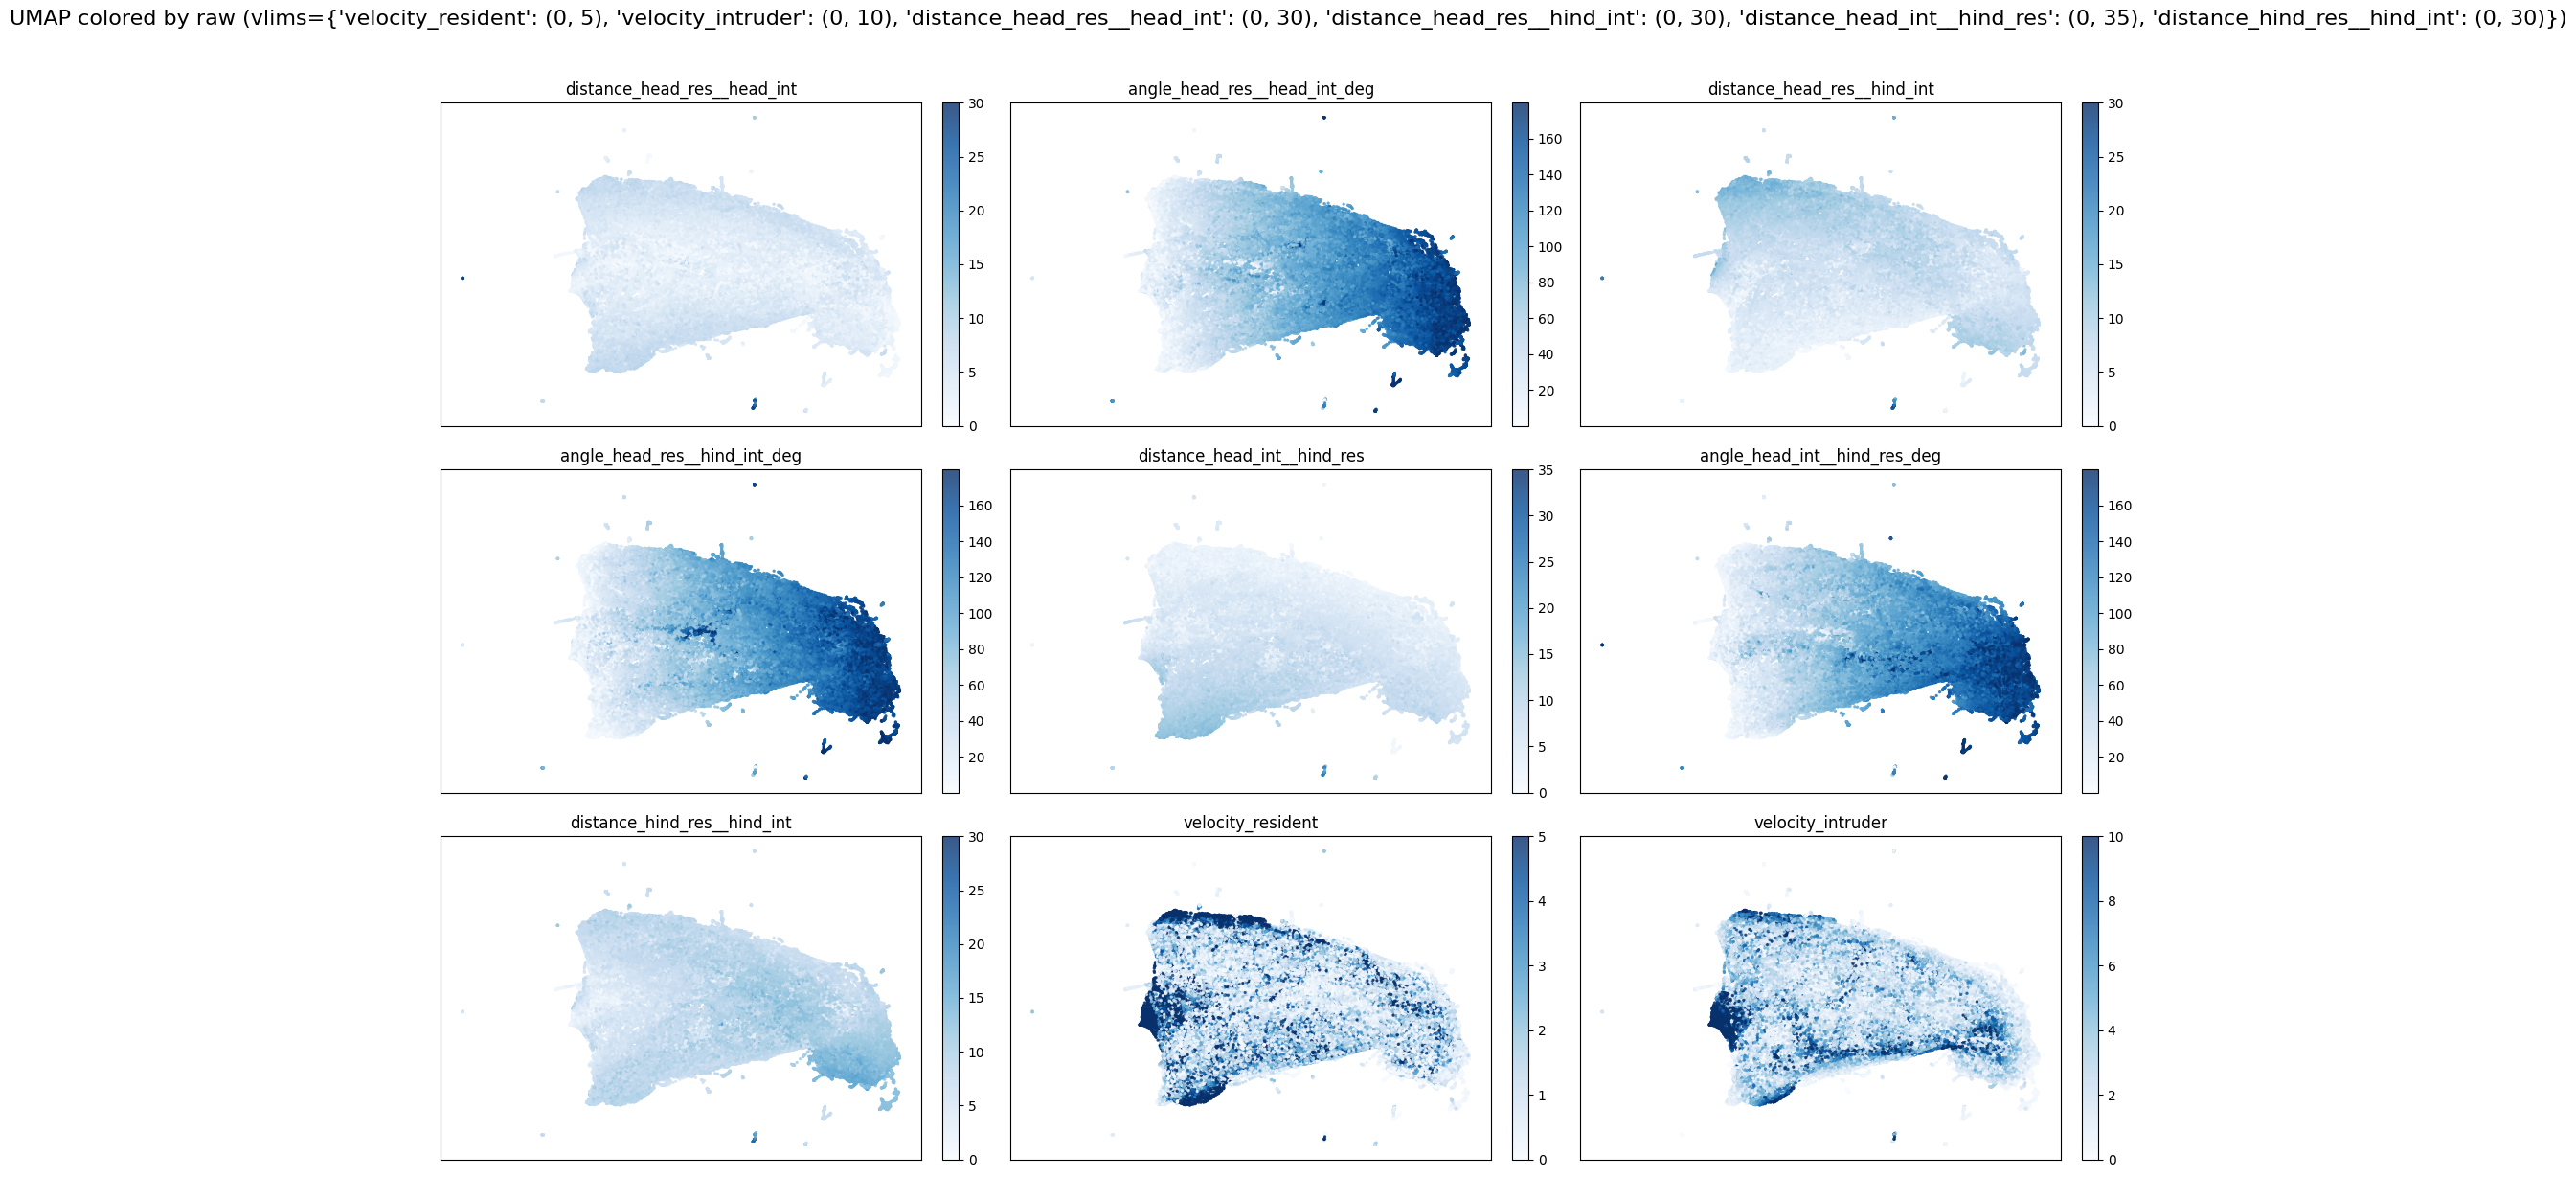

In [ ]:
# only plot your two velocities, forcing resident to 0–10 but auto-scaling intruder
plot_feature_grid(
    df_all,
    feats=features,
    vals="raw",
    raw_vlims={"velocity_resident": (0,5),
                "velocity_intruder": (0,10),
                "distance_head_res__head_int": (0,30) ,
                "distance_head_res__hind_int": (0,30),
                "distance_head_int__hind_res": (0,35),
                "distance_hind_res__hind_int": (0,30),
    }
)

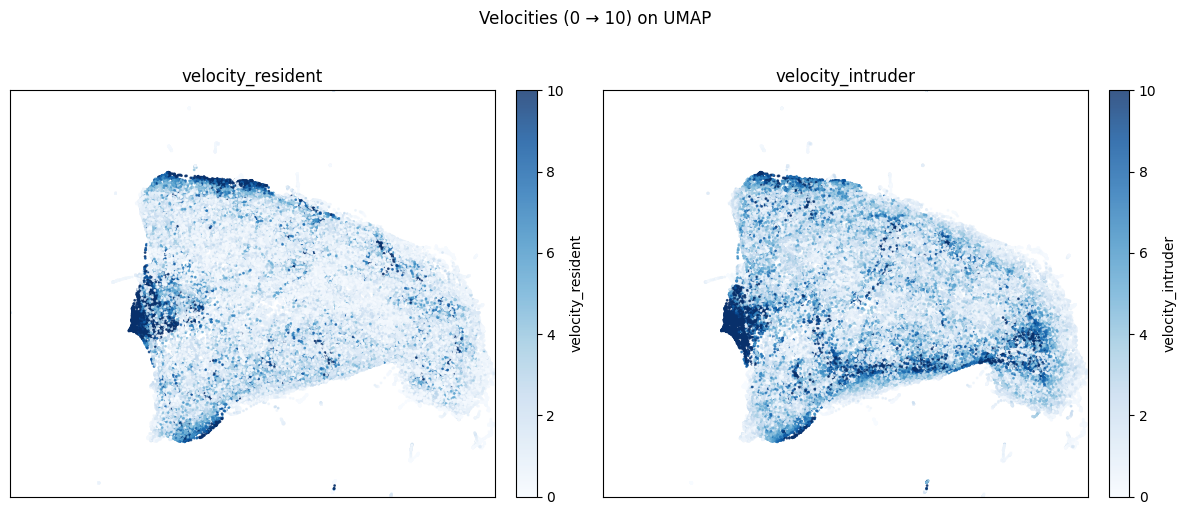

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_velocities(df_umap, vmin=0, vmax=10, cmap="Blues", s=1):
    feats = ["velocity_resident", "velocity_intruder"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    x = df_umap["umap1"].values
    y = df_umap["umap2"].values
    xlim = (x.min(), x.max())
    ylim = (y.min(), y.max())

    for ax, feat in zip(axes, feats):
        sc = ax.scatter(
            x, y,
            c=df_umap[feat],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=s, alpha=0.8
        )
        ax.set_title(feat)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(feat)

    plt.suptitle(f"Velocities (0 → {vmax}) on UMAP", y=1.02)
    plt.tight_layout()
    plt.show()

plot_velocities(df_all, vmin=0, vmax=10, cmap="Blues", s=1)


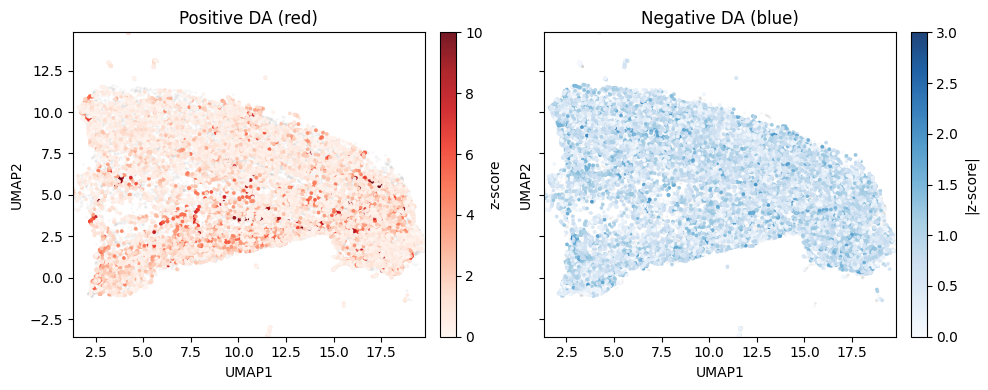

In [11]:
import numpy as np
import matplotlib.pyplot as plt

mask_region = df["brain_region"].eq("NAc")          # or drop if you want all
sub = df[mask_region].copy()

# split
pos = sub[sub.zscore_DA > 0]
neg = sub[sub.zscore_DA < 0]

# common axis limits & magnitude range
xlim = (sub.umap1.min(), sub.umap1.max())
ylim = (sub.umap2.min(), sub.umap2.max())
lim  = np.nanmax(np.abs(sub.zscore_DA))             # symmetric max

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# ---- POSITIVE (red) ----
ax = axes[0]
ax.scatter(sub.umap1, sub.umap2, s=1, color="lightgray", alpha=0.12, zorder=0)
sc1 = ax.scatter(pos.umap1, pos.umap2,
                 c=pos.zscore_DA, cmap="Reds",
                 vmin=0, vmax=10, s=3, alpha=0.9, zorder=1)
ax.set_title("Positive DA (red)")
ax.set_xlim(xlim); ax.set_ylim(ylim)
cbar1 = fig.colorbar(sc1, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label("z-score")

# ---- NEGATIVE (blue) ----
ax = axes[1]
ax.scatter(sub.umap1, sub.umap2, s=1, color="lightgray", alpha=0.12, zorder=0)
# color by absolute value so scale matches
sc2 = ax.scatter(neg.umap1, neg.umap2,
                 c=np.abs(neg.zscore_DA), cmap="Blues",
                 vmin=0, vmax=3, s=3, alpha=0.9, zorder=1)
ax.set_title("Negative DA (blue)")
cbar2 = fig.colorbar(sc2, ax=ax, fraction=0.046, pad=0.04)
cbar2.set_label("|z-score|")

for ax in axes:
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

plt.tight_layout()
plt.show()


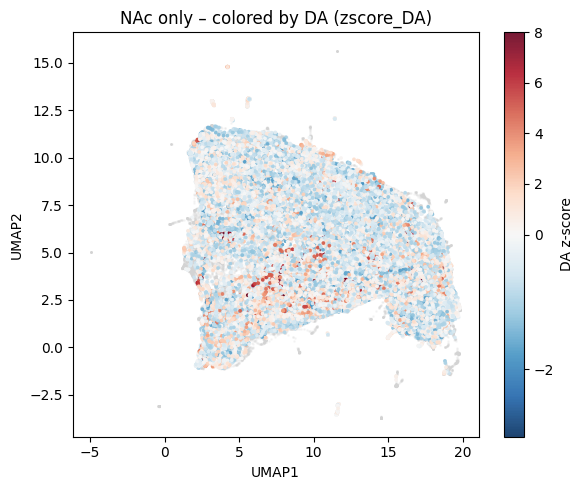

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

mask = df["brain_region"].eq("NAc")

# --- choose limits ---
# Option A: hard clip
vmin, vmax = -3, 8

# Option B: robust percentiles (still symmetric)
# vals = df.loc[mask, "zscore_DA"].to_numpy()
# lim = max(abs(np.percentile(vals, 2)), abs(np.percentile(vals, 98)))
# vmin, vmax = -lim, lim

norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.figure(figsize=(6,5))
plt.scatter(df.loc[~mask, "umap1"], df.loc[~mask, "umap2"],
            s=1, color="lightgray", alpha=0.15)

sc = plt.scatter(df.loc[mask, "umap1"],
                 df.loc[mask, "umap2"],
                 c=df.loc[mask, "zscore_DA"],
                 cmap="RdBu_r", norm=norm,
                 s=3, alpha=0.9)

cbar = plt.colorbar(sc)
cbar.set_label("DA z-score")
# cbar.set_ticks([vmin, -1.5, 0, 1.5, vmax])

plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title("NAc only – colored by DA (zscore_DA)")
plt.tight_layout(); plt.show()


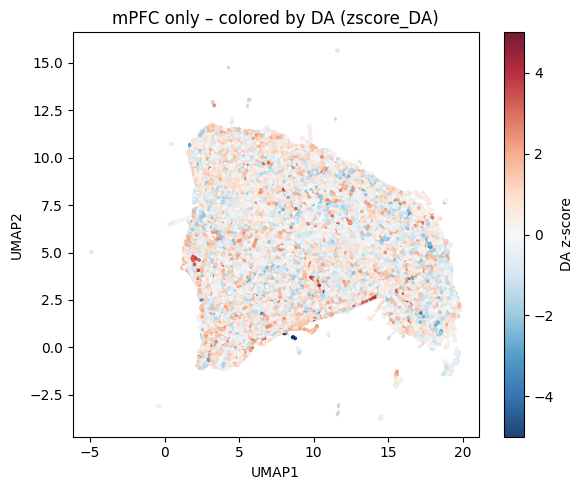

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

mask = df["brain_region"].eq("mPFC")

# --- choose limits ---
# Option A: hard clip
vmin, vmax = -5, 5

# Option B: robust percentiles (still symmetric)
# vals = df.loc[mask, "zscore_DA"].to_numpy()
# lim = max(abs(np.percentile(vals, 2)), abs(np.percentile(vals, 98)))
# vmin, vmax = -lim, lim

norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.figure(figsize=(6,5))
plt.scatter(df.loc[~mask, "umap1"], df.loc[~mask, "umap2"],
            s=1, color="lightgray", alpha=0.15)

sc = plt.scatter(df.loc[mask, "umap1"],
                 df.loc[mask, "umap2"],
                 c=df.loc[mask, "zscore_DA"],
                 cmap="RdBu_r", norm=norm,
                 s=3, alpha=0.9)

cbar = plt.colorbar(sc)
cbar.set_label("DA z-score")
# cbar.set_ticks([vmin, -1.5, 0, 1.5, vmax])

plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title("mPFC only – colored by DA (zscore_DA)")
plt.tight_layout(); plt.show()


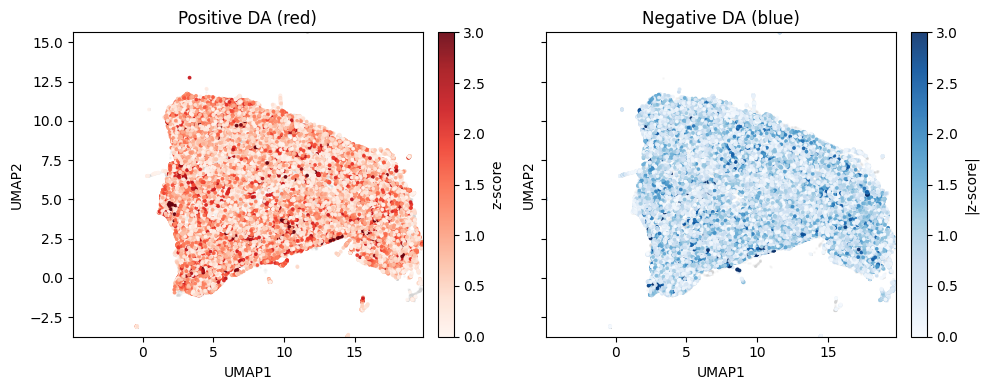

In [14]:
import numpy as np
import matplotlib.pyplot as plt

mask_region = df["brain_region"].eq("mPFC")          # or drop if you want all
sub = df[mask_region].copy()

# split
pos = sub[sub.zscore_DA > 0]
neg = sub[sub.zscore_DA < 0]

# common axis limits & magnitude range
xlim = (sub.umap1.min(), sub.umap1.max())
ylim = (sub.umap2.min(), sub.umap2.max())
lim  = np.nanmax(np.abs(sub.zscore_DA))             # symmetric max

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# ---- POSITIVE (red) ----
ax = axes[0]
ax.scatter(sub.umap1, sub.umap2, s=1, color="lightgray", alpha=0.12, zorder=0)
sc1 = ax.scatter(pos.umap1, pos.umap2,
                 c=pos.zscore_DA, cmap="Reds",
                 vmin=0, vmax=3, s=3, alpha=0.9, zorder=1)
ax.set_title("Positive DA (red)")
ax.set_xlim(xlim); ax.set_ylim(ylim)
cbar1 = fig.colorbar(sc1, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label("z-score")

# ---- NEGATIVE (blue) ----
ax = axes[1]
ax.scatter(sub.umap1, sub.umap2, s=1, color="lightgray", alpha=0.12, zorder=0)
# color by absolute value so scale matches
sc2 = ax.scatter(neg.umap1, neg.umap2,
                 c=np.abs(neg.zscore_DA), cmap="Blues",
                 vmin=0, vmax=3, s=3, alpha=0.9, zorder=1)
ax.set_title("Negative DA (blue)")
cbar2 = fig.colorbar(sc2, ax=ax, fraction=0.046, pad=0.04)
cbar2.set_label("|z-score|")

for ax in axes:
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

plt.tight_layout()
plt.show()


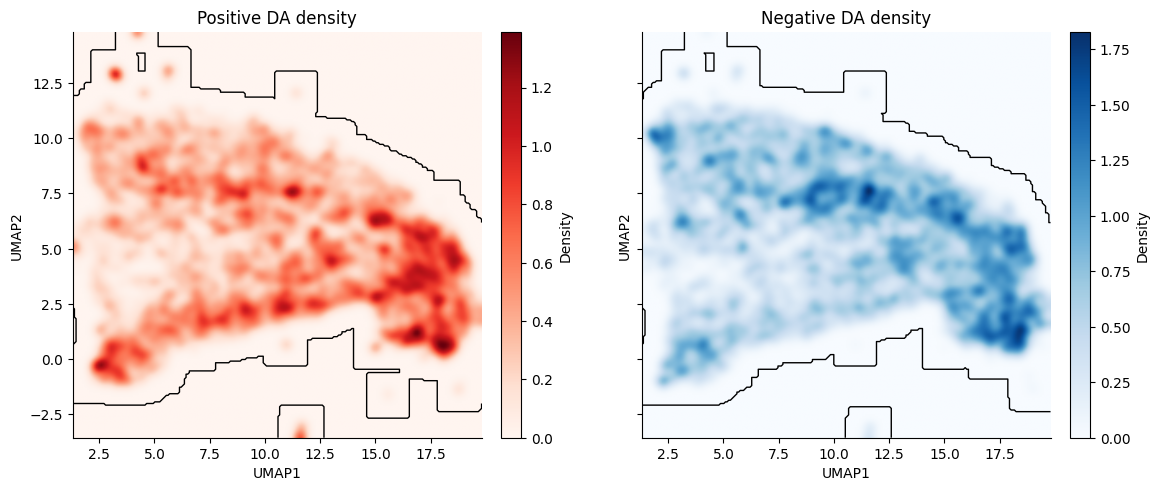

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def plot_positive_negative_density(df, region=None,
                                   bins=200, sigma=2.5,
                                   pos_cmap="Reds", neg_cmap="Blues",
                                   thresh_frac=0.01):
    """
    Plot separate density maps for positive vs. negative zscore_DA on UMAP.
    
    df : DataFrame with 'umap1','umap2','zscore_DA','brain_region' columns
    region : if not None, mask df[df.brain_region==region]
    """
    # 1) optionally restrict to one brain region
    if region is not None:
        df = df[df["brain_region"] == region].copy()
        
    # 2) make global grid & extent
    x = df["umap1"].values
    y = df["umap2"].values
    xlim, ylim = (x.min(), x.max()), (y.min(), y.max())
    xedges = np.linspace(*xlim, bins+1)
    yedges = np.linspace(*ylim, bins+1)
    
    # helper to compute smoothed histogram
    def density(arr_x, arr_y):
        H, _, _ = np.histogram2d(arr_x, arr_y,
                                 bins=[xedges, yedges])
        H = gaussian_filter(H, sigma=sigma)
        return H.T  # transpose for imshow
    
    # 3) split pos / neg
    pos = df[df["zscore_DA"] > 0]
    neg = df[df["zscore_DA"] < 0]
    
    # 4) compute densities
    H_pos = density(pos.umap1.values, pos.umap2.values)
    H_neg = density(neg.umap1.values, neg.umap2.values)
    
    # 5) threshold levels for plotting (so we don’t draw everywhere)
    lvl_pos = np.nanpercentile(H_pos, 100*thresh_frac)
    lvl_neg = np.nanpercentile(H_neg, 100*thresh_frac)
    
    extent = [xlim[0], xlim[1], ylim[0], ylim[1]]
    
    # 6) plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
    
    # positive
    im1 = ax1.imshow(H_pos, origin="lower", extent=extent,
                     cmap=pos_cmap, interpolation="bilinear")
    ax1.contour(H_pos, levels=[lvl_pos], colors="k",
                linewidths=1, extent=extent)
    ax1.set_title("Positive DA density")
    cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label("Density")
    
    # negative
    im2 = ax2.imshow(H_neg, origin="lower", extent=extent,
                     cmap=neg_cmap, interpolation="bilinear")
    ax2.contour(H_neg, levels=[lvl_neg], colors="k",
                linewidths=1, extent=extent)
    ax2.set_title("Negative DA density")
    cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label("Density")
    
    for ax in (ax1, ax2):
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_positive_negative_density(df, region="NAc", bins=250, sigma=3,
                               pos_cmap="Reds", neg_cmap="Blues",
                               thresh_frac=0.02)


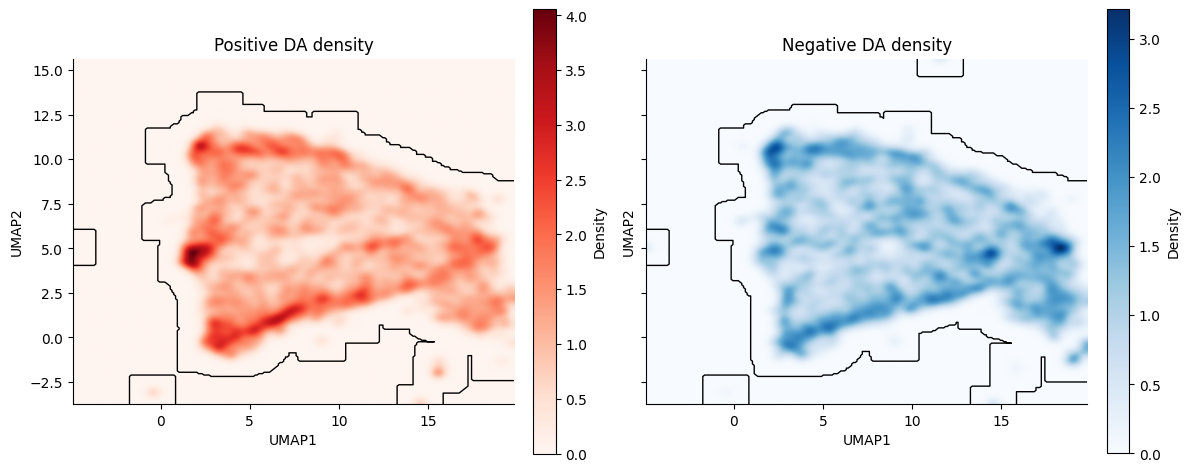

In [16]:
plot_positive_negative_density(df, region="mPFC", bins=250, sigma=3,
                               pos_cmap="Reds", neg_cmap="Blues",
                               thresh_frac=0.02)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def plot_top_da_density(
    df,
    pct=0.90,                 # e.g. 0.90 → top 10%
    region: str | None = None,# "NAc", "mPFC", or None for all
    bins=250,
    sigma=2.5,
    cmap="hot",
    outline_frac=0.05,
):
    """
    Show density of only the top‐pct DA z‑scores on UMAP, optionally restricted to one brain region.
    
    Parameters
    ----------
    df : DataFrame
        Must contain 'umap1','umap2','zscore_DA','brain_region'.
    pct : float in (0,1)
        Keep only rows with zscore_DA >= its pct‑quantile.
    region : str or None
        If not None, only use df[df.brain_region==region] for thresholding and plotting.
    bins, sigma, cmap, outline_frac : as before.
    """
    # 0) optionally restrict to region for *both* threshold and outline
    if region is not None:
        df = df[df["brain_region"] == region]
        if df.empty:
            raise ValueError(f"No rows found for region '{region}'")
    
    # 1) compute threshold
    thr = df["zscore_DA"].quantile(pct)
    df_top = df[df["zscore_DA"] >= thr]
    if df_top.empty:
        raise ValueError(f"No points above the {100*pct:.0f}th percentile in region '{region}'!")

    # 2) global grid & outline from *all* (region‑filtered) points
    x_all = df["umap1"].values
    y_all = df["umap2"].values
    xmin, xmax = x_all.min(), x_all.max()
    ymin, ymax = y_all.min(), y_all.max()
    xedges = np.linspace(xmin, xmax, bins+1)
    yedges = np.linspace(ymin, ymax, bins+1)

    H_all, _, _ = np.histogram2d(x_all, y_all, bins=[xedges, yedges])
    H_all = gaussian_filter(H_all, sigma=sigma).T
    outline_level = np.nanpercentile(H_all, outline_frac*100)

    # 3) density of top‐pct
    x = df_top["umap1"].values
    y = df_top["umap2"].values
    H_top, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
    H_top = gaussian_filter(H_top, sigma=sigma).T

    extent = [xmin, xmax, ymin, ymax]

    # 4) plot
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(
        H_top,
        origin="lower",
        extent=extent,
        interpolation="bilinear",
        cmap=cmap
    )
    ax.contour(
        H_all,
        levels=[outline_level],
        colors="k",
        linewidths=1.5,
        extent=extent,
        origin="lower"
    )
    tit = f"{region} – " if region else ""
    tit += f"UMAP density of DA ≥ {thr:.2f} (top {100*(1-pct):.0f}%)"
    cbar = fig.colorbar(im, ax=ax, label=f"Density of top {100*(1-pct):.0f}% DA")
    ax.set_title(tit)
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
    for sp in ("top","right"):
        ax.spines[sp].set_visible(False)
    plt.tight_layout()
    plt.show()


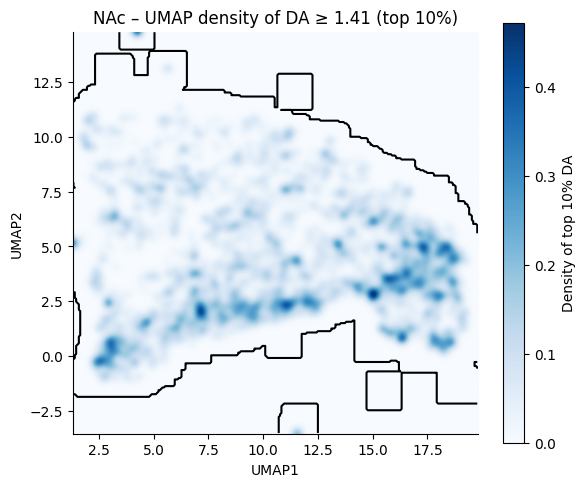

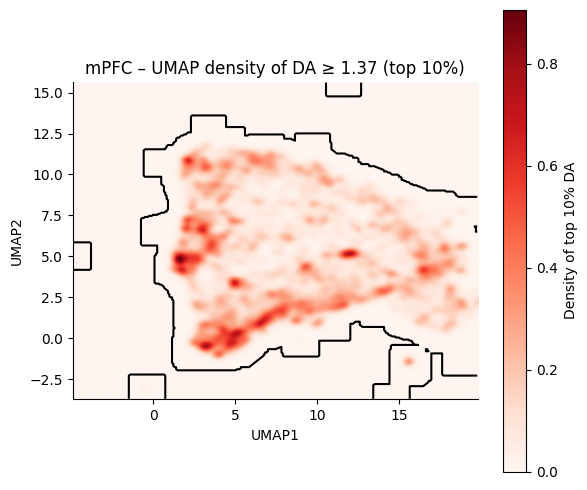

In [18]:
# top 10% in NAc
plot_top_da_density(df, pct=0.90, region="NAc", bins=300, sigma=3, cmap="Blues")

# top 5% in mPFC
plot_top_da_density(df, pct=0.90, region="mPFC", bins=300, sigma=3, cmap="Reds")

# top 10% across both regions
# plot_top_da_density(df, pct=0.90, region=None, bins=300, sigma=3, cmap="hot")


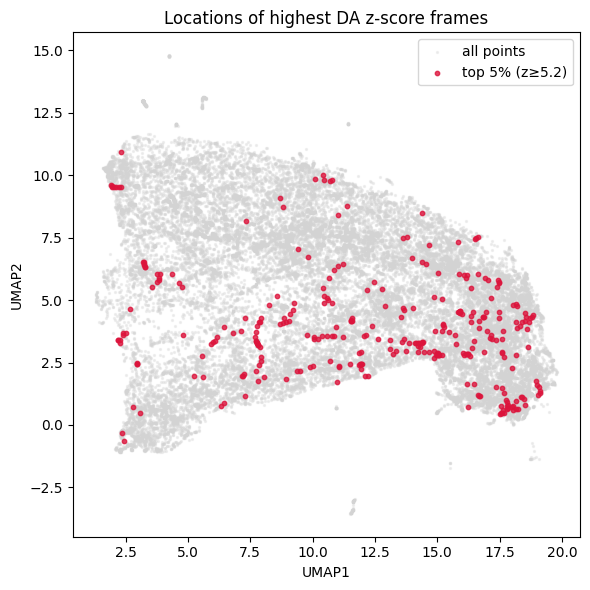

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1) mask for your brain region if you want (or use df directly)
mask = df["brain_region"].eq("NAc")
sub  = df.loc[mask]

# 2) pick a threshold, e.g. 95th percentile of DA z‑score
thresh = sub["zscore_DA"].quantile(0.99)

# 3) split into “high” and “rest”
high = sub[sub["zscore_DA"] >= thresh]
rest = sub[sub["zscore_DA"] <  thresh]

# 4) scatter everything lightly, then overlay the high‐DA points in bold
plt.figure(figsize=(6,6))
plt.scatter(rest["umap1"], rest["umap2"],
            s=2, color="lightgray", alpha=0.3, label="all points")

plt.scatter(high["umap1"], high["umap2"],
            s=10, color="crimson", alpha=0.8, label=f"top 5% (z≥{thresh:.1f})")

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(loc="upper right")
plt.title("Locations of highest DA z‑score frames")
plt.tight_layout()
plt.show()


In [20]:
# # ========= imports =========
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.colors import TwoSlopeNorm
# from scipy.ndimage import gaussian_filter
# from sklearn.neighbors import KernelDensity
# import seaborn as sns
# import math

# # df must have: umap1, umap2, zscore_DA, behavior_active (may be NaN)

# # ========= helpers =========
# def make_grid(x, y, nx=400, ny=400):
#     xmin, xmax = x.min(), x.max()
#     ymin, ymax = y.min(), y.max()
#     xi = np.linspace(xmin, xmax, nx)
#     yi = np.linspace(ymin, ymax, ny)
#     Xi, Yi = np.meshgrid(xi, yi)
#     return xi, yi, Xi, Yi, (xmin, xmax, ymin, ymax)

# def kde_density(x, y, Xi, Yi, bw=0.35, sigma=2):
#     xy = np.c_[x, y]
#     kde = KernelDensity(bandwidth=bw).fit(xy)
#     Z = np.exp(kde.score_samples(np.c_[Xi.ravel(), Yi.ravel()])).reshape(Xi.shape)
#     return gaussian_filter(Z, sigma=sigma)

# def binned_mean(x, y, val, xi, yi, sigma=2):
#     nx, ny = len(xi), len(yi)
#     acc   = np.zeros((ny, nx))
#     count = np.zeros((ny, nx))

#     ix = np.searchsorted(xi, x) - 1
#     iy = np.searchsorted(yi, y) - 1
#     valid = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)&np.isfinite(val)

#     np.add.at(acc,   (iy[valid], ix[valid]), val[valid])
#     np.add.at(count, (iy[valid], ix[valid]), 1)

#     mean = np.divide(acc, count, out=np.full_like(acc, np.nan), where=count>0)
#     return gaussian_filter(mean, sigma=sigma)

# # ========= 1) Density “water paint” =========
# def plot_density(df, cmap="Blues", levels=25, bw=0.35, sigma=2):
#     xi, yi, Xi, Yi, ext = make_grid(df.umap1.values, df.umap2.values)
#     Z = kde_density(df.umap1.values, df.umap2.values, Xi, Yi, bw=bw, sigma=sigma)

#     fig, ax = plt.subplots(figsize=(5,4))
#     cs = ax.contourf(Xi, Yi, Z, levels=levels, cmap=cmap)
#     ax.contour(Xi, Yi, Z, levels=levels, colors="k", linewidths=0.4, alpha=0.4)
#     ax.set_xlim(ext[0], ext[1]); ax.set_ylim(ext[2], ext[3])
#     ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
#     fig.colorbar(cs, ax=ax, label="Density")
#     plt.tight_layout(); plt.show()

# # ========= 2) Signal “water paint” (e.g., DA z-score) =========
# def plot_signal(df, value_col="zscore_DA",
#                 vmin=-3, vcenter=0, vmax=3,
#                 cmap="RdBu_r", bw=0.35, sigma=2):
#     x, y, v = df.umap1.values, df.umap2.values, df[value_col].values
#     xi, yi, Xi, Yi, ext = make_grid(x, y)
#     # base density (optional) for drawing an outline
#     dens = kde_density(x, y, Xi, Yi, bw=bw, sigma=1.5)
#     # mean value field
#     M = binned_mean(x, y, v, xi, yi, sigma=sigma)

#     norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
#     fig, ax = plt.subplots(figsize=(5,4))
#     im = ax.imshow(M, extent=[ext[0],ext[1],ext[2],ext[3]],
#                    origin="lower", cmap=cmap, norm=norm,
#                    interpolation="bilinear")
#     # optional outline around high-density region
#     ax.contour(Xi, Yi, dens, levels=[np.nanpercentile(dens, 60)],
#                colors="k", linewidths=1.5)

#     cb = fig.colorbar(im, ax=ax, label=value_col)
#     ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
#     plt.tight_layout(); plt.show()

# # ========= 3) Behavior maps (one panel per behavior, incl. NaN/None) =========
# def plot_behavior_panels(df, beh_col="behavior_active",
#                          ncols=3, cmap="Blues",
#                          bw=0.35, sigma=2, thresh_pct=50):
#     df2 = df.copy()
#     df2[beh_col] = df2[beh_col].fillna("None")
#     behaviors = sorted(df2[beh_col].unique())

#     xi, yi, Xi, Yi, ext = make_grid(df2.umap1.values, df2.umap2.values)
#     n = len(behaviors)
#     nrows = math.ceil(n / ncols)
#     fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
#     axes = np.ravel(axes)

#     for ax, beh in zip(axes, behaviors):
#         sub = df2[df2[beh_col]==beh]
#         if len(sub) < 5:
#             ax.axis("off"); continue
#         Z = kde_density(sub.umap1.values, sub.umap2.values, Xi, Yi, bw=bw, sigma=sigma)
#         lvl = np.nanpercentile(Z, thresh_pct)
#         ax.contourf(Xi, Yi, Z, levels=25, cmap=("Greys" if beh=="None" else cmap))
#         ax.contour(Xi, Yi, Z, levels=[lvl], colors="k", linewidths=1.2)
#         ax.set_xlim(ext[0], ext[1]); ax.set_ylim(ext[2], ext[3])
#         ax.set_title(beh)
#         ax.set_xticks([]); ax.set_yticks([])
#         # clean top/right
#         ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

#     for ax in axes[len(behaviors):]:
#         ax.axis("off")

#     plt.suptitle("UMAP density per behavior (including None)", y=1.02)
#     plt.tight_layout(); plt.show()

# # ========= run =========
# plot_density(df)
# plot_signal(df, value_col="zscore_DA")
# plot_behavior_panels(df)


# This code doesn't work - takes too long to run

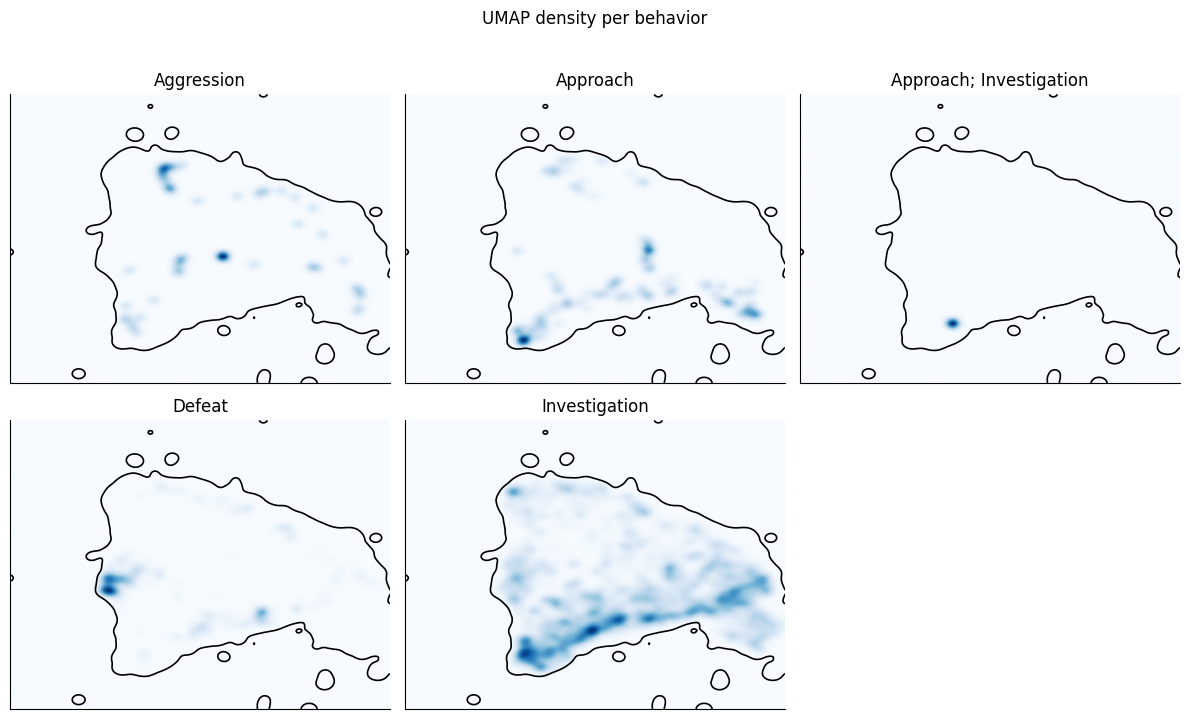

In [21]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_behavior_panels_fast(df, beh_col="behavior_active",
                              ncols=3, bins=250, sigma=3,
                              cmap="Blues", outline_pct=60):
    """
    Fast density maps per behavior using 2D histograms + blur.
    One global UMAP outline is drawn on every panel.
    """
    # keep only labeled behaviors
    df2 = df[df[beh_col].notna()].copy()
    behaviors = sorted(df2[beh_col].unique())
    if not behaviors:
        raise ValueError("No behaviors found (all NaN).")

    # ----- common grid -----
    x = df["umap1"].values
    y = df["umap2"].values
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xedges = np.linspace(xmin, xmax, bins+1)
    yedges = np.linspace(ymin, ymax, bins+1)

    # global density & outline level (same for all panels)
    H_all, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
    H_all = gaussian_filter(H_all, sigma=sigma)
    outline_level = np.nanpercentile(H_all, outline_pct)

    # coordinates for contour
    Xc = np.linspace(xmin, xmax, H_all.shape[0])
    Yc = np.linspace(ymin, ymax, H_all.shape[1])

    # ----- plotting -----
    n = len(behaviors)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
    axes = np.ravel(axes)

    for ax, beh in zip(axes, behaviors):
        sub = df2[df2[beh_col] == beh]

        H, _, _ = np.histogram2d(sub["umap1"], sub["umap2"],
                                 bins=[xedges, yedges])
        H = gaussian_filter(H, sigma=sigma)

        ax.imshow(H.T, origin="lower",
                  extent=[xmin, xmax, ymin, ymax],
                  cmap=cmap, aspect="auto")

        # draw ONE global outline
        ax.contour(Xc, Yc, H_all.T, levels=[outline_level],
                   colors="k", linewidths=1.2)

        ax.set_title(beh)
        ax.set_xticks([]); ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # blank leftover axes
    for ax in axes[len(behaviors):]:
        ax.axis("off")

    plt.suptitle("UMAP density per behavior", y=1.02)
    plt.tight_layout()
    plt.show()
plot_behavior_panels_fast(df, beh_col="behavior_active", ncols=3)


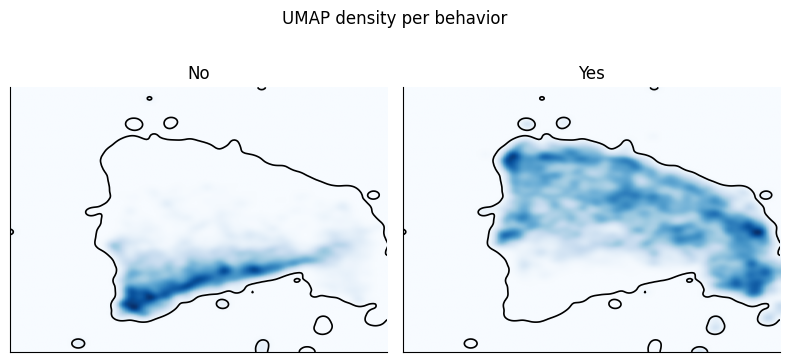

In [ ]:
plot_behavior_panels_fast(df, beh_col="agent_in_subject", ncols=2)

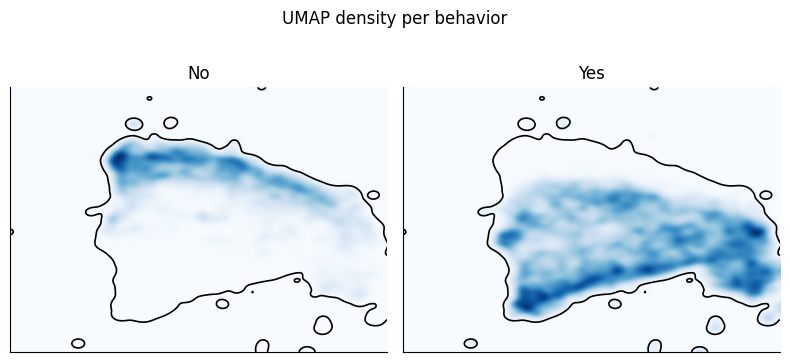

In [45]:
plot_behavior_panels_fast(df, beh_col="subject_in_agent", ncols=2)


In [22]:
df.columns

Index(['time_s', 'brain_region', 'mouse_identity', 'zscore_DA',
       'intruder_identity', 'agent_in_subject', 'subject_in_agent',
       'distance_head_res__head_int', 'angle_head_res__head_int_deg',
       'distance_head_res__hind_int', 'angle_head_res__hind_int_deg',
       'distance_head_int__hind_res', 'angle_head_int__hind_res_deg',
       'distance_hind_res__hind_int', 'velocity_resident', 'velocity_intruder',
       'behavior_active', 'umap1', 'umap2'],
      dtype='object')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import gaussian_filter

def plot_behavior_panels_excl(
    df, *,
    beh_col="behavior_active",
    reference_df=None,   # NEW! full‐data reference for grid/outline
    ncols=3,
    bins=250,
    sigma=3,
    cmap="Blues",
    outline_pct=60
):
    """
    Fast density maps per behavior using 2D histograms + blur,
    but computed on df ⊆ reference_df so the UMAP axes & outline
    remain identical to the reference.
    """
    # 1) panel classes
    df2 = df[df[beh_col].notna()].copy()
    behaviors = sorted(df2[beh_col].unique())
    if not behaviors:
        raise ValueError("No behaviors found (all NaN).")

    # 2) pick the reference for grid & global outline
    df_ref = reference_df if reference_df is not None else df
    x_all = df_ref["umap1"].values
    y_all = df_ref["umap2"].values

    # 3) common grid / global density
    x_min, x_max = x_all.min(), x_all.max()
    y_min, y_max = y_all.min(), y_all.max()
    xedges = np.linspace(x_min, x_max, bins+1)
    yedges = np.linspace(y_min, y_max, bins+1)

    H_all, _, _ = np.histogram2d(x_all, y_all, bins=[xedges, yedges])
    H_all = gaussian_filter(H_all, sigma=sigma)
    outline_level = np.nanpercentile(H_all, outline_pct)

    Xc = np.linspace(x_min, x_max, H_all.shape[0])
    Yc = np.linspace(y_min, y_max, H_all.shape[1])

    # 4) make panels
    n = len(behaviors)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
    axes = np.ravel(axes)

    for ax, beh in zip(axes, behaviors):
        sub = df2[df2[beh_col] == beh]
        H, _, _ = np.histogram2d(sub["umap1"], sub["umap2"],
                                 bins=[xedges, yedges])
        H = gaussian_filter(H, sigma=sigma)

        ax.imshow(H.T, origin="lower",
                  extent=[x_min, x_max, y_min, y_max],
                  cmap=cmap, aspect="auto")
        # same global outline
        ax.contour(Xc, Yc, H_all.T, levels=[outline_level],
                   colors="k", linewidths=1.2)

        ax.set_title(beh)
        ax.set_xticks([]); ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # blank leftover
    for ax in axes[len(behaviors):]:
        ax.axis("off")

    plt.suptitle("UMAP density per “exclusive” mask", y=1.02)
    plt.tight_layout()
    plt.show()


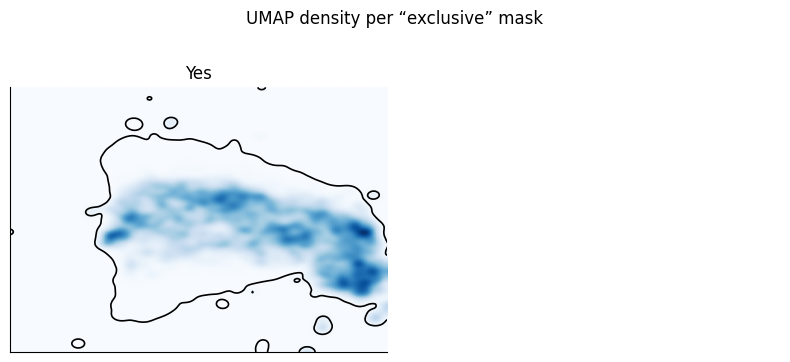

In [24]:
mask_exclusive = (
    (df_all["agent_in_subject"] == "Yes") &
    (df_all["subject_in_agent"] == "Yes")
)
df_both = df_all.loc[mask_exclusive].copy()

plot_behavior_panels_excl(
    df_both,
    beh_col="subject_in_agent",
    reference_df=df_all,
    ncols=2
)


In [25]:
import numpy as np

def _social_context(row):
    s2a = (row["subject_in_agent"]   == "Yes")
    a2s = (row["agent_in_subject"]   == "Yes")
    if s2a and a2s:
        return "Both"
    elif s2a:
        return "Subject→Agent only"
    elif a2s:
        return "Agent→Subject only"
    else:
        return "None"

df_all["social_context"] = df_all.apply(_social_context, axis=1)


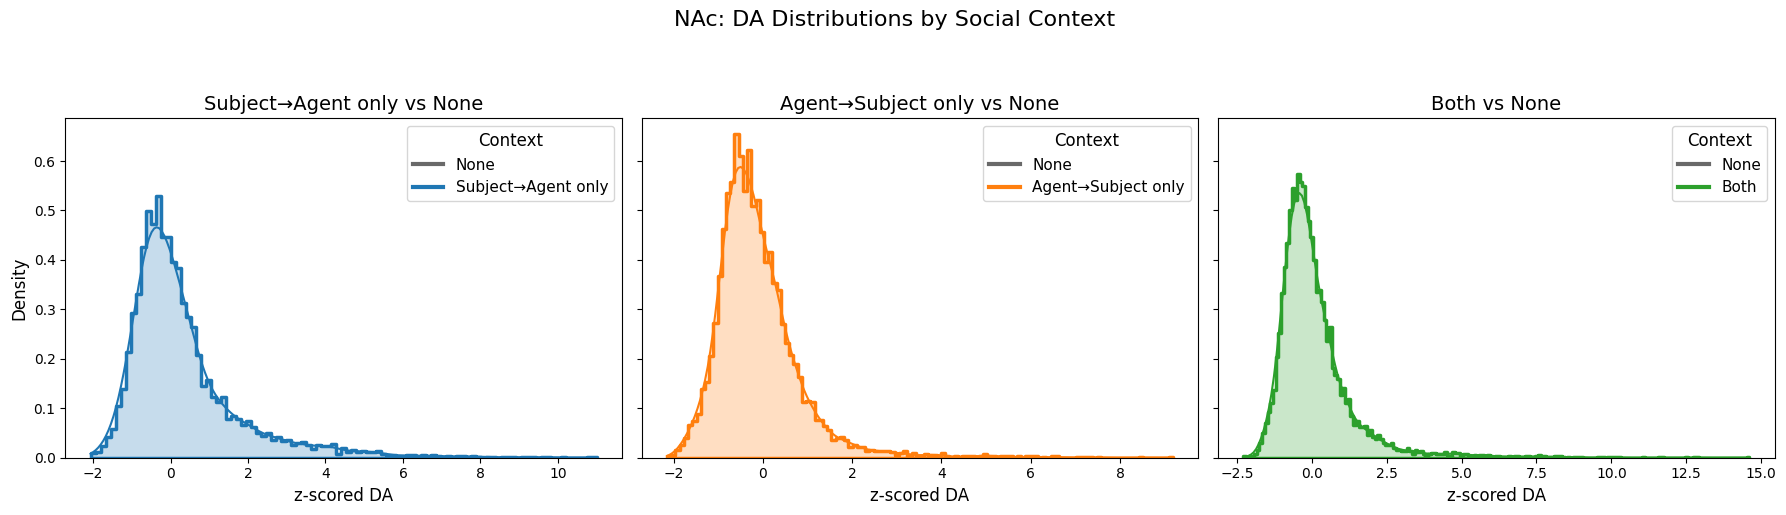

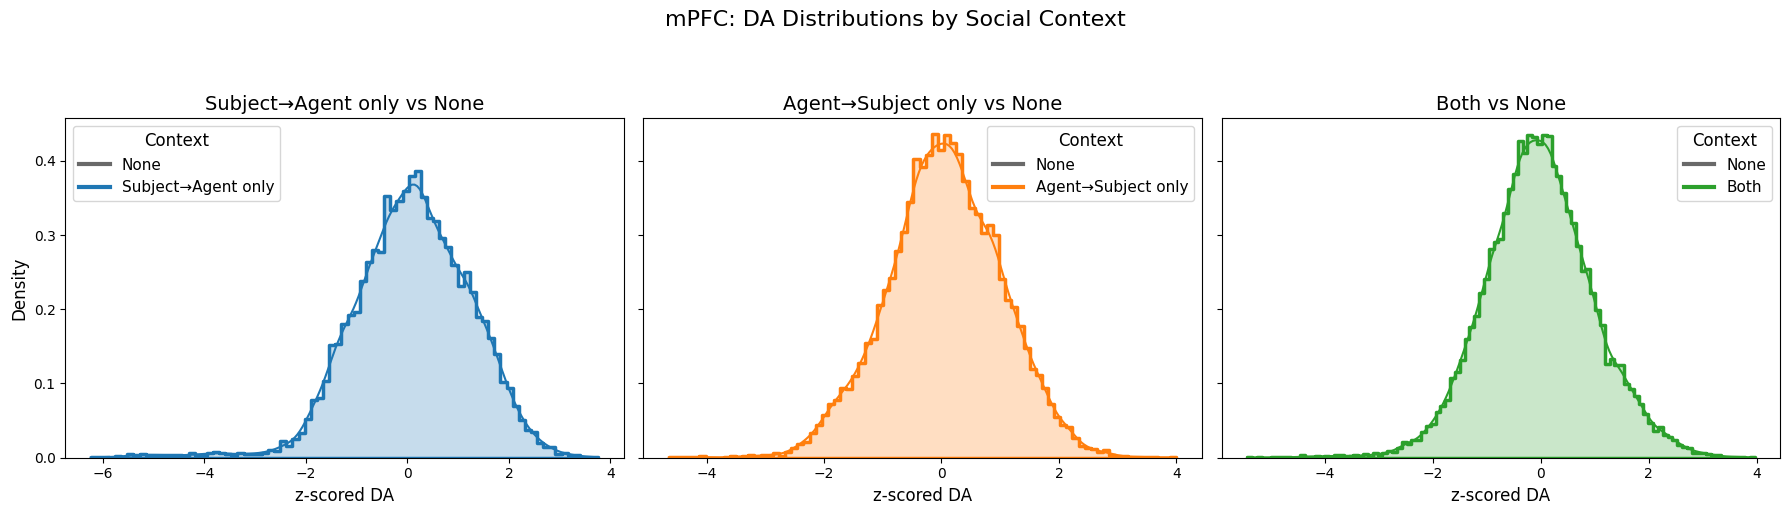

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Define your three cases and a darker gray for “None”
cases = ["Subject→Agent only", "Agent→Subject only", "Both"]
palette = {
    "None":               "dimgray",
    "Subject→Agent only": "C0",
    "Agent→Subject only": "C1",
    "Both":               "C2"
}

for region in sorted(df_all["brain_region"].unique()):
    df_reg = df_all[df_all["brain_region"] == region]
    if df_reg.empty:
        continue

    # Make the figure larger
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, case in zip(axes, cases):
        # select rows where context is None or this case
        df_pair = df_reg[df_reg["social_context"].isin(["None", case])]
        if df_pair.empty:
            ax.axis("off")
            continue

        sns.histplot(
            data        = df_pair,
            x           = "zscore_DA",
            hue         = "social_context",
            hue_order   = ["None", case],
            palette     = palette,
            element     = "step",
            stat        = "density",
            common_norm = False,
            kde         = True,
            linewidth   = 2.5,        # thicker step lines
            ax          = ax
        )
        ax.set_title(f"{case} vs None", fontsize=14)
        ax.set_xlabel("z-scored DA", fontsize=12)
        if ax is axes[0]:
            ax.set_ylabel("Density", fontsize=12)
        else:
            ax.set_ylabel("")

        # manually add legend with darker border colors
        handles = [
            Line2D([0], [0], color=palette["None"],               lw=3, label="None"),
            Line2D([0], [0], color=palette[case],                  lw=3, label=case)
        ]
        ax.legend(handles=handles, title="Context", fontsize=11, title_fontsize=12)

    fig.suptitle(f"{region}: DA Distributions by Social Context", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


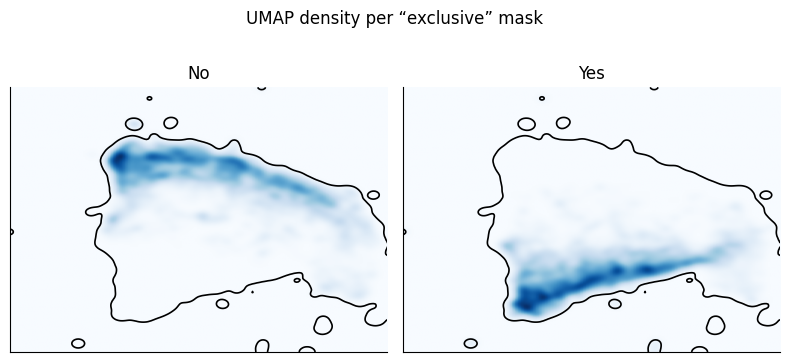

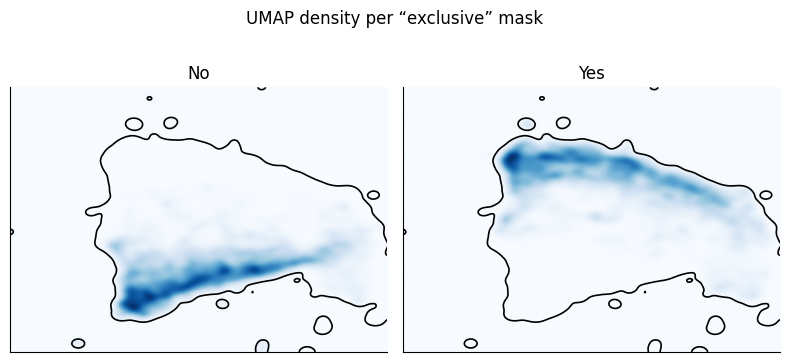

In [27]:
# build the exclusive mask (exactly one of the two is Yes)
mask_exclusive = (
    (df_all["agent_in_subject"] == "Yes") ^
    (df_all["subject_in_agent"] == "Yes")
)
df_excl = df_all.loc[mask_exclusive].copy()

# plot subject_in_agent = Yes/No panels on the same UMAP grid
plot_behavior_panels_excl(
    df_excl,
    beh_col="subject_in_agent",
    reference_df=df_all,
    ncols=2
)

plot_behavior_panels_excl(
    df_excl,
    beh_col="agent_in_subject",
    reference_df=df_all,
    ncols=2
)


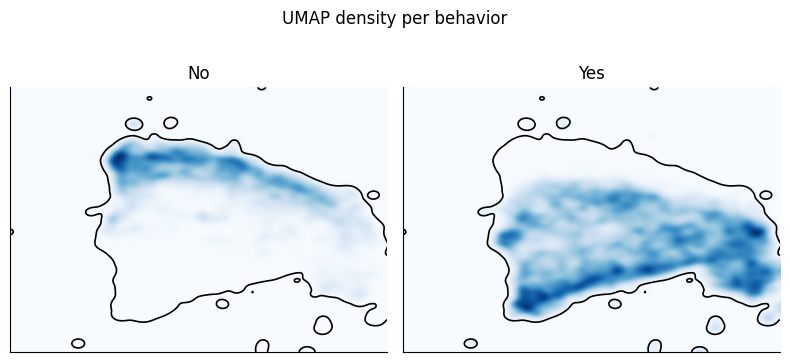

In [28]:
plot_behavior_panels_fast(df, beh_col="subject_in_agent", ncols=2)

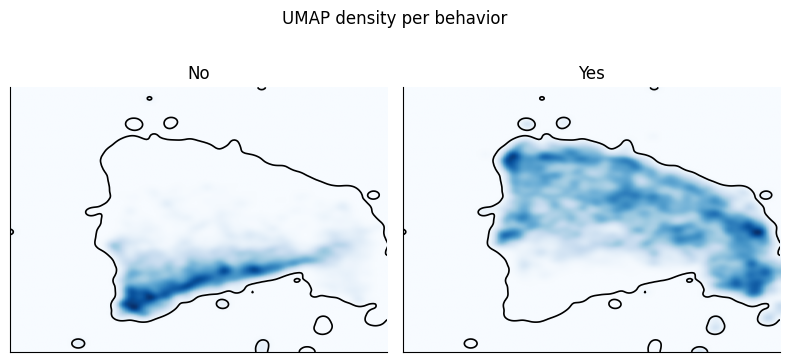

In [29]:
plot_behavior_panels_fast(df, beh_col="agent_in_subject", ncols=2)

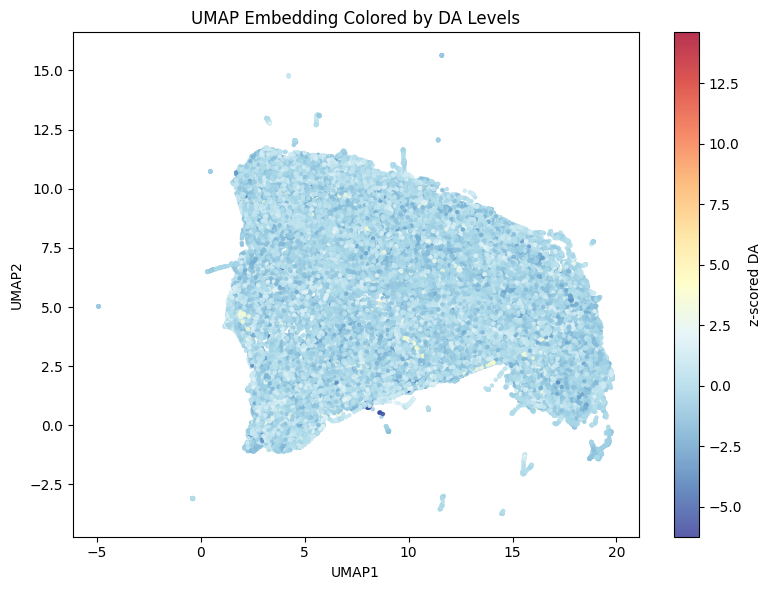

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df_all["umap1"],
    df_all["umap2"],
    c=df_all["zscore_DA"],        # color by DA level
    cmap="RdYlBu_r",               # diverging colormap
    s=5,                           # point size
    alpha=0.8
)
plt.colorbar(sc, label="z-scored DA")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Embedding Colored by DA Levels")
plt.tight_layout()
plt.show()


C:\Users\alber\AppData\Local\Temp\ipykernel_6752\2677547675.py:40: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


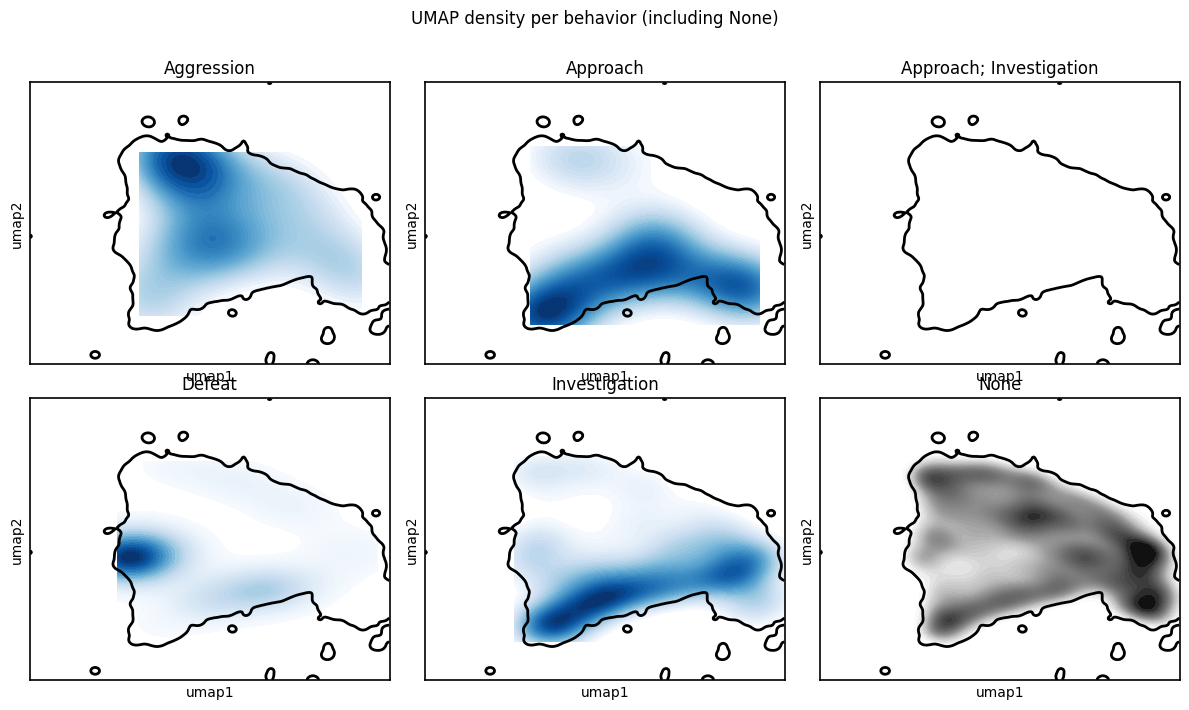

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.ndimage import gaussian_filter

beh_col = "behavior_active"

# keep NaNs as a label if you want them shown
df_plot = df.copy()
df_plot[beh_col] = df_plot[beh_col].fillna("None")

behaviors = sorted(df_plot[beh_col].unique())
n = len(behaviors); ncols = 3; nrows = math.ceil(n/ncols)

# ---------- global limits (same scale) ----------
xlim = (df_plot["umap1"].min(), df_plot["umap1"].max())
ylim = (df_plot["umap2"].min(), df_plot["umap2"].max())

# ---------- precompute a "barrier" contour for *all* points ----------
# histogram -> smooth -> contour level
bins   = 250
sigma  = 2.5
H, xe, ye = np.histogram2d(df_plot["umap1"], df_plot["umap2"], bins=bins,
                           range=[xlim, ylim])
H = gaussian_filter(H, sigma=sigma)
H = H.T  # for imshow/contour
extent = [xe[0], xe[-1], ye[0], ye[-1]]

# choose an outer contour level (0–max). Tweak if too tight/loose.
level = 0.05 * H.max()

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.4*nrows))
axes = axes.ravel()

for ax, beh in zip(axes, behaviors):
    sub = df_plot[df_plot[beh_col] == beh]

    # density of this behavior
    sns.kdeplot(
        x=sub["umap1"], y=sub["umap2"],
        fill=True, thresh=0.05, levels=40,
        cmap="Blues" if beh != "None" else "Greys",
        ax=ax, bw_adjust=1.2, gridsize=180, cut=0
    )

    # overlay global boundary contour
    ax.contour(H, levels=[level], colors='k', linewidths=2,
               extent=extent, origin='lower')

    # make spines (top/right included)
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.2)

    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')   # same scale on x & y
    ax.set_title(beh)
    ax.set_xticks([]); ax.set_yticks([])

# hide unused axes
for ax in axes[len(behaviors):]:
    ax.axis("off")

plt.suptitle("UMAP density per behavior (including None)", y=1.02)
plt.tight_layout()
plt.show()


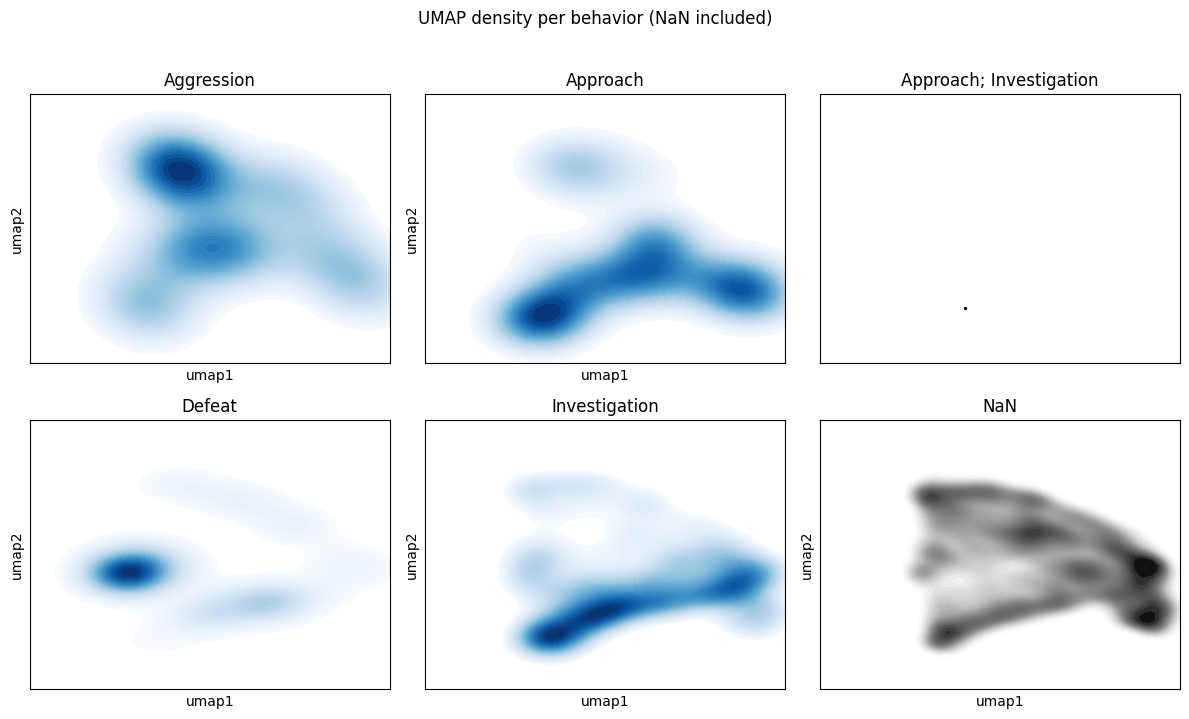

In [32]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, math

beh_col = "behavior_active"

df_plot = df.copy()
df_plot["beh_for_plot"] = df_plot[beh_col].astype(object)
df_plot.loc[df_plot[beh_col].isna(), "beh_for_plot"] = "NaN"   # own class

behaviors = sorted(df_plot["beh_for_plot"].unique())
n = len(behaviors); ncols = 3; nrows = math.ceil(n / ncols)

xlim = (df_plot["umap1"].min(), df_plot["umap1"].max())
ylim = (df_plot["umap2"].min(), df_plot["umap2"].max())

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
axes = axes.ravel()

for ax, beh in zip(axes, behaviors):
    sub = df_plot[df_plot["beh_for_plot"] == beh]
    cmap = "Greys" if beh == "NaN" else "Blues"

    # fallback: if too few points for KDE, just scatter
    if len(sub) < 10:
        ax.scatter(sub["umap1"], sub["umap2"], s=2, color="k")
    else:
        sns.kdeplot(x=sub["umap1"], y=sub["umap2"],
                    fill=True, thresh=0.05, levels=50,
                    cmap=cmap, ax=ax)

    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_title(beh); ax.set_xticks([]); ax.set_yticks([])

for ax in axes[len(behaviors):]:
    ax.axis("off")

plt.suptitle("UMAP density per behavior (NaN included)", y=1.02)
plt.tight_layout()
plt.show()


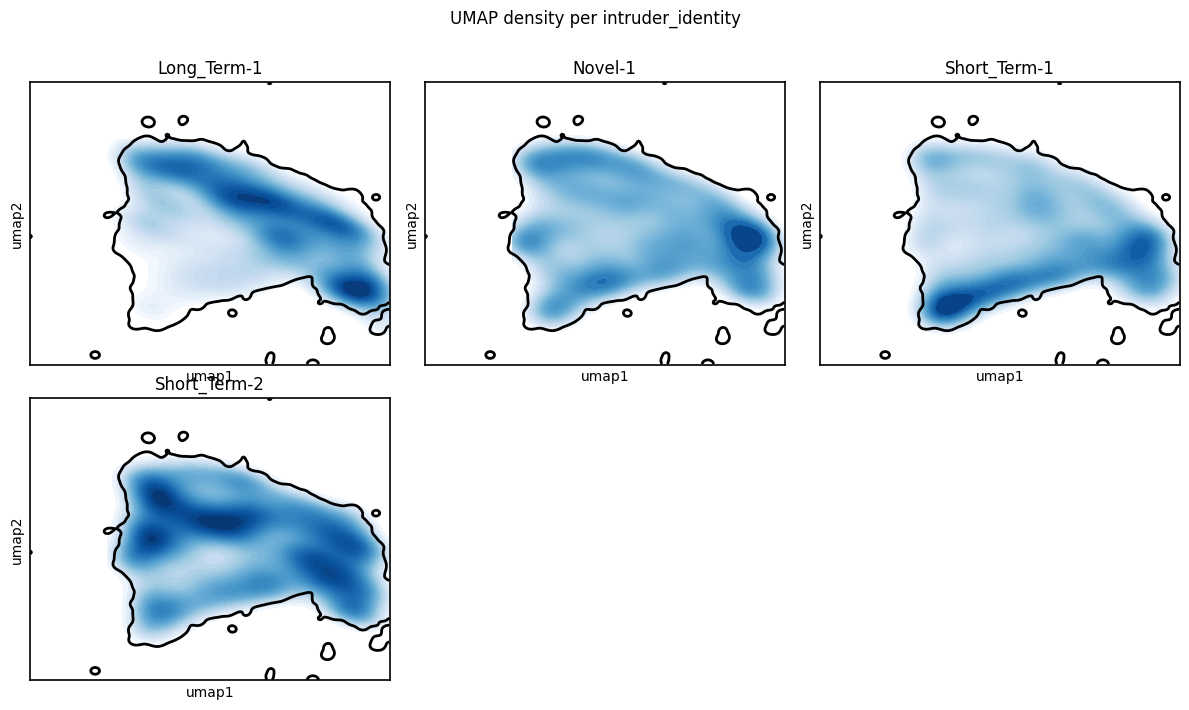

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import math

def plot_umap_density_by(df,
                         group_col="intruder_identity",
                         ncols=3,
                         bins=250,
                         sigma=2.5,
                         cmap="Blues",
                         none_label="None",
                         use_prefix=False,   # collapse "Short_Term_1" -> "Short_Term"
                         outline_frac=0.05): # 5% of max density for border
    # -------- prep labels --------
    df2 = df.copy()
    if use_prefix:
        df2[group_col] = df2[group_col].astype(str).str.split("_").str[0]
    df2[group_col] = df2[group_col].fillna(none_label)

    groups = sorted(df2[group_col].unique())
    n = len(groups); nrows = math.ceil(n / ncols)

    # -------- common limits and global outline --------
    x = df2["umap1"].to_numpy()
    y = df2["umap2"].to_numpy()
    xlim = (x.min(), x.max())
    ylim = (y.min(), y.max())

    H, xe, ye = np.histogram2d(x, y, bins=bins, range=[xlim, ylim])
    H = gaussian_filter(H, sigma=sigma).T
    extent = [xe[0], xe[-1], ye[0], ye[-1]]
    level  = outline_frac * np.nanmax(H)

    # -------- plot --------
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.4*nrows))
    axes = axes.ravel()

    for ax, g in zip(axes, groups):
        sub = df2[df2[group_col] == g]

        sns.kdeplot(
            x=sub["umap1"], y=sub["umap2"],
            fill=True, thresh=0.05, levels=40,
            cmap="Greys" if g == none_label else cmap,
            ax=ax, bw_adjust=1.2, gridsize=180, cut=0
        )

        ax.contour(H, levels=[level], colors='k', linewidths=2,
                   extent=extent, origin='lower')

        for side in ("top","right","bottom","left"):
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(1.2)

        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_aspect("equal")
        ax.set_title(g)
        ax.set_xticks([]); ax.set_yticks([])

    # blank leftovers
    for ax in axes[len(groups):]:
        ax.axis("off")

    plt.suptitle(f"UMAP density per {group_col}", y=1.02)
    plt.tight_layout()
    plt.show()

plot_umap_density_by(df,
                     group_col="intruder_identity",
                     ncols=3,
                     use_prefix=False)   # <- keep 1 vs 2 separate


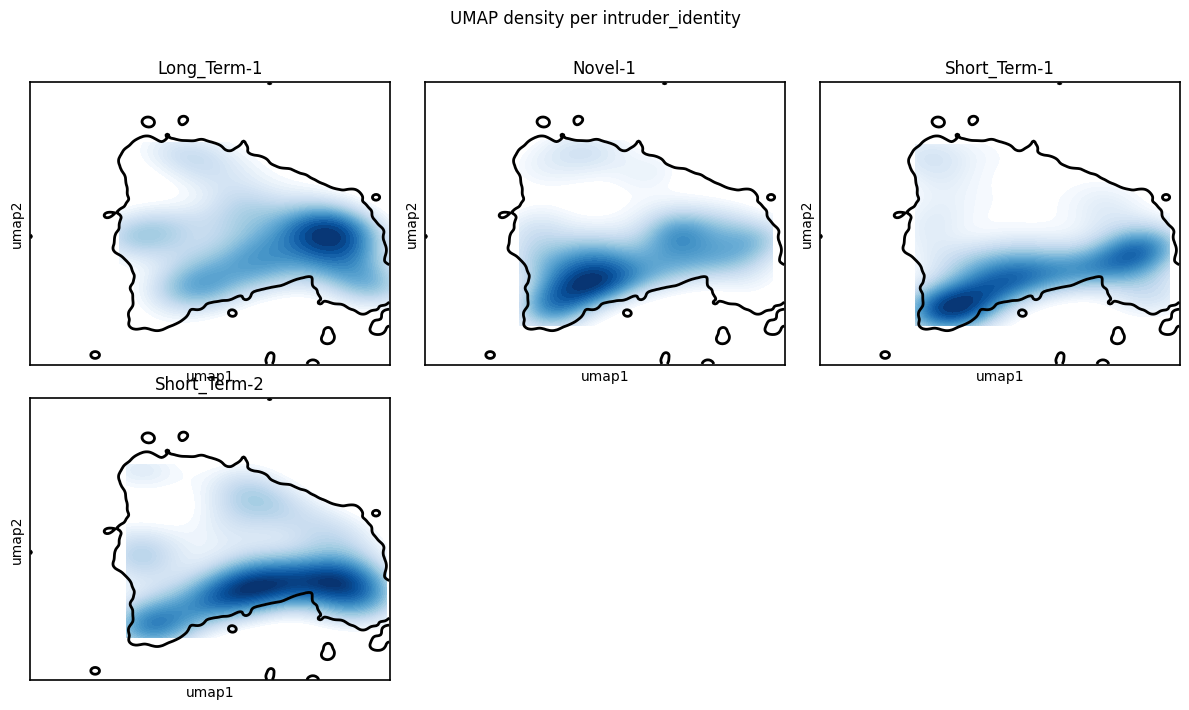

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import math

def plot_umap_density_by(df_plot,                    # the data to plot (e.g. only Investigation)
                         group_col="intruder_identity",
                         outline_df=None,            # data used to build the global border
                         ncols=3,
                         bins=250, sigma=2.5,
                         cmap="Blues",
                         none_label="None",
                         outline_frac=0.05):
    """
    Density maps per group with ONE global border drawn on every panel.
    df_plot : rows to visualize (e.g. Investigation only)
    outline_df : rows to build the border (defaults to df_plot if None)
    """
    if outline_df is None:
        outline_df = df_plot

    # ---------- prep labels ----------
    df2 = df_plot.copy()
    df2[group_col] = df2[group_col].fillna(none_label)
    groups = sorted(df2[group_col].unique())
    n = len(groups); nrows = math.ceil(n / ncols)

    # ---------- common limits & global outline ----------
    x_all = outline_df["umap1"].to_numpy()
    y_all = outline_df["umap2"].to_numpy()
    xlim = (x_all.min(), x_all.max())
    ylim = (y_all.min(), y_all.max())

    H, xe, ye = np.histogram2d(x_all, y_all, bins=bins, range=[xlim, ylim])
    H = gaussian_filter(H, sigma=sigma).T
    extent = [xe[0], xe[-1], ye[0], ye[-1]]
    level  = outline_frac * np.nanmax(H)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.4*nrows))
    axes = axes.ravel()

    for ax, g in zip(axes, groups):
        sub = df2[df2[group_col] == g]

        sns.kdeplot(
            x=sub["umap1"], y=sub["umap2"],
            fill=True, thresh=0.05, levels=40,
            cmap="Greys" if g == none_label else cmap,
            ax=ax, bw_adjust=1.2, gridsize=180, cut=0
        )

        # global border
        ax.contour(H, levels=[level], colors='k', linewidths=2,
                   extent=extent, origin='lower')

        # cosmetics
        for s in ("top","right","bottom","left"):
            ax.spines[s].set_visible(True)
            ax.spines[s].set_linewidth(1.2)

        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_aspect("equal")
        ax.set_title(g)
        ax.set_xticks([]); ax.set_yticks([])

    for ax in axes[len(groups):]:
        ax.axis("off")

    plt.suptitle(f"UMAP density per {group_col}", y=1.02)
    plt.tight_layout(); plt.show()

# 1) Investigation-only rows
mask_inv = df["behavior_active"].str.contains("Investigation", na=False)
df_inv   = df.loc[mask_inv & df["intruder_identity"].notna()]

# 2) Plot: densities from df_inv, border from ALL frames
plot_umap_density_by(df_inv,
                     group_col="intruder_identity",
                     outline_df=df,     # <- old border
                     ncols=3,
                     cmap="Blues")


C:\Users\alber\AppData\Local\Temp\ipykernel_6752\4059912191.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


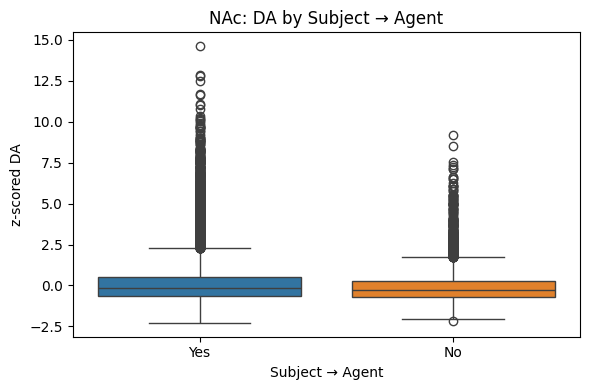

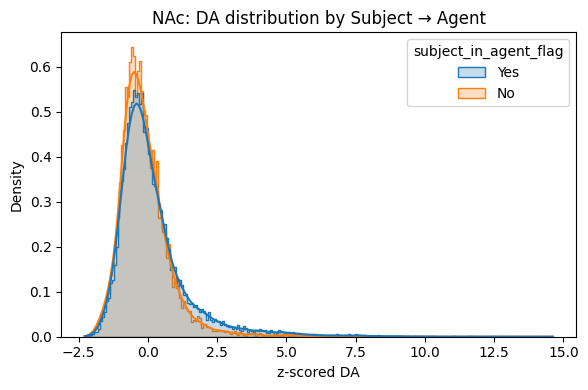

C:\Users\alber\AppData\Local\Temp\ipykernel_6752\4059912191.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


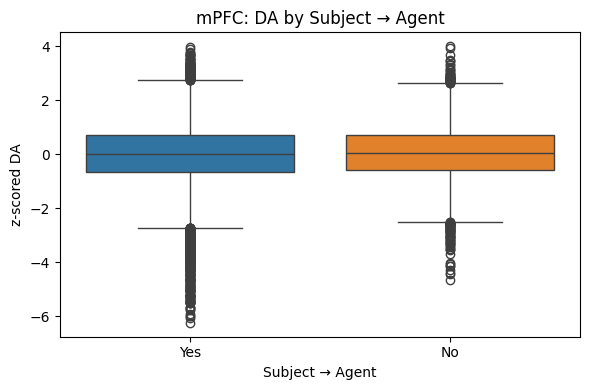

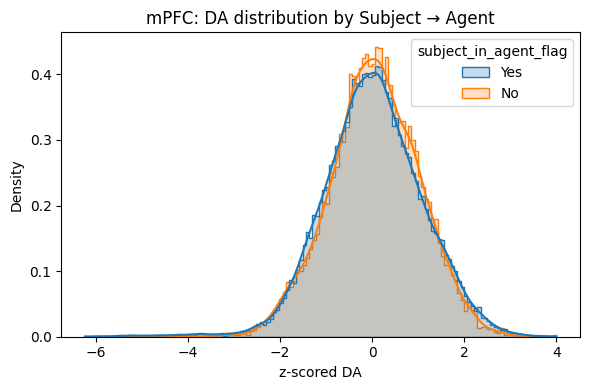

C:\Users\alber\AppData\Local\Temp\ipykernel_6752\4059912191.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


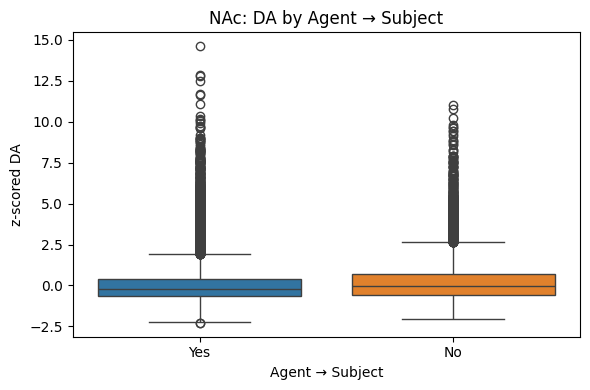

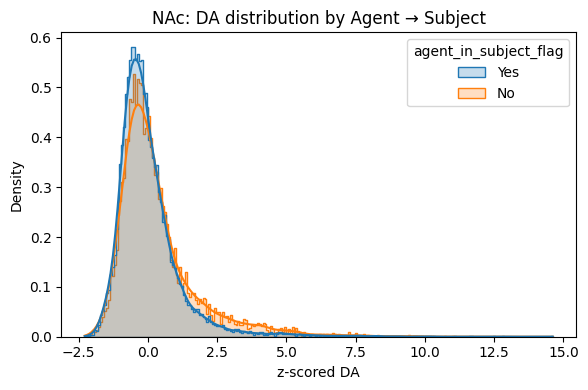

C:\Users\alber\AppData\Local\Temp\ipykernel_6752\4059912191.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


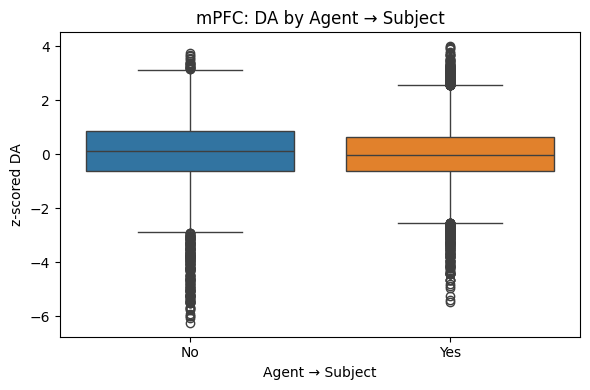

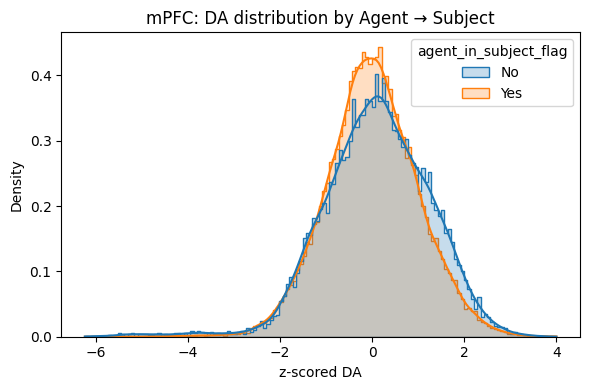

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the flag columns exist
df_all["subject_in_agent_flag"] = df_all["subject_in_agent"].map({"Yes":"Yes","No":"No"})
df_all["agent_in_subject_flag"]  = df_all["agent_in_subject"].map({"Yes":"Yes","No":"No"})

# Loop over the two masks
for mask_col, title in [
    ("subject_in_agent_flag", "Subject → Agent"),
    ("agent_in_subject_flag",  "Agent → Subject")
]:
    # restrict to rows where the flag is defined
    df_mask = df_all[df_all[mask_col].isin(["Yes", "No"])]

    # Loop over each brain region present
    for region in sorted(df_mask["brain_region"].unique()):
        df_reg = df_mask[df_mask["brain_region"] == region]

        # 1) Box‐and‐whisker plot
        plt.figure(figsize=(6,4))
        sns.boxplot(
            x=mask_col,
            y="zscore_DA",
            data=df_reg,
            palette=["C0","C1"]
        )
        plt.xlabel(title)
        plt.ylabel("z‐scored DA")
        plt.title(f"{region}: DA by {title}")
        plt.tight_layout()
        plt.show()

        # 2) Overlaid histograms + KDE
        plt.figure(figsize=(6,4))
        sns.histplot(
            df_reg,
            x="zscore_DA",
            hue=mask_col,
            element="step",
            stat="density",
            common_norm=False,
            kde=True,
            palette=["C0","C1"]
        )
        plt.xlabel("z‐scored DA")
        plt.ylabel("Density")
        plt.title(f"{region}: DA distribution by {title}")
        plt.tight_layout()
        plt.show()


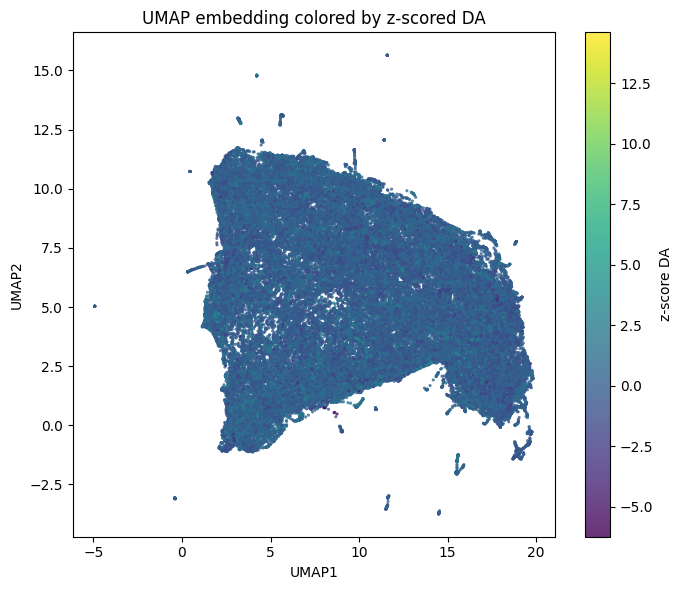

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# assume df_all has columns "umap1", "umap2", and "zscore_DA"
x = df_all["umap1"].to_numpy()
y = df_all["umap2"].to_numpy()
c = df_all["zscore_DA"].to_numpy()

plt.figure(figsize=(7,6))
sc = plt.scatter(
    x, y,
    c=c,
    cmap="viridis",
    s=5,
    alpha=0.8,
    edgecolors="none"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP embedding colored by z-scored DA")
cbar = plt.colorbar(sc)
cbar.set_label("z-score DA")
plt.tight_layout()
plt.show()


DBSCAN

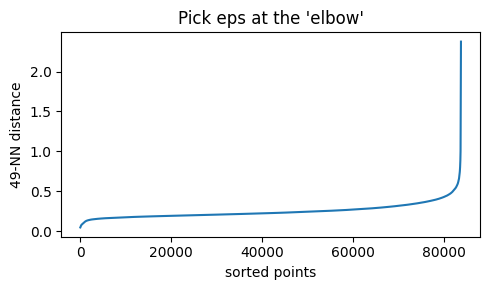

clusters: 3, noise pts: 14554


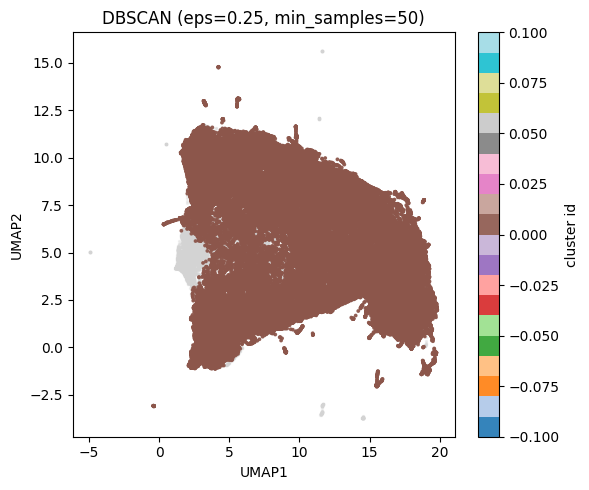

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Choose eps with a k-distance plot ----------
min_samples = 50          # tweak! (~ few % of your points or > dim*2)
k = min_samples - 1

nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
dists, _ = nbrs.kneighbors(X_scaled)
kdist = np.sort(dists[:, -1])   # distance to k-th neighbor

plt.figure(figsize=(5,3))
plt.plot(kdist)
plt.ylabel(f"{k}-NN distance"); plt.xlabel("sorted points")
plt.title("Pick eps at the 'elbow'")
plt.tight_layout(); plt.show()

# After eyeballing the elbow, set eps:
eps = 0.25   # <-- replace with the elbow you see

# ---------- 2. Run DBSCAN ----------
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
labels = db.fit_predict(X_scaled)

df["dbscan"] = labels                 # -1 = noise
n_clusters = 3#len(set(labels)) - (1 if -1 in labels else 0)
print(f"clusters: {n_clusters}, noise pts: {(labels==-1).sum()}")

# ---------- 3. Visualize on UMAP ----------
plt.figure(figsize=(6,5))
# noise in light gray
mask_noise = df["dbscan"].eq(-1)
plt.scatter(df.loc[mask_noise, "umap1"], df.loc[mask_noise, "umap2"],
            s=2, c="lightgray", alpha=0.3, label="noise")

# clusters
sc = plt.scatter(df.loc[~mask_noise, "umap1"], df.loc[~mask_noise, "umap2"],
                 c=df.loc[~mask_noise, "dbscan"], s=3, cmap="tab20", alpha=0.9)

plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})")
plt.colorbar(sc, label="cluster id")
plt.tight_layout(); plt.show()


In [38]:
# from sklearn.cluster import DBSCAN
# import numpy as np
# import pandas as pd

# def sweep_dbscan(X, eps_list, min_samples=60):
#     rows = []
#     for e in eps_list:
#         labels = DBSCAN(eps=e, min_samples=min_samples, n_jobs=-1).fit_predict(X)
#         k = len(set(labels)) - (1 if -1 in labels else 0)
#         noise = (labels == -1).mean()
#         rows.append({"eps": e, "clusters": k, "noise_frac": noise})
#     return pd.DataFrame(rows)

# eps_grid = np.arange(0.20, 0.46, 0.05)
# summ = sweep_dbscan(X_scaled, eps_grid, min_samples=60)
# print(summ)


Traditional Clustering

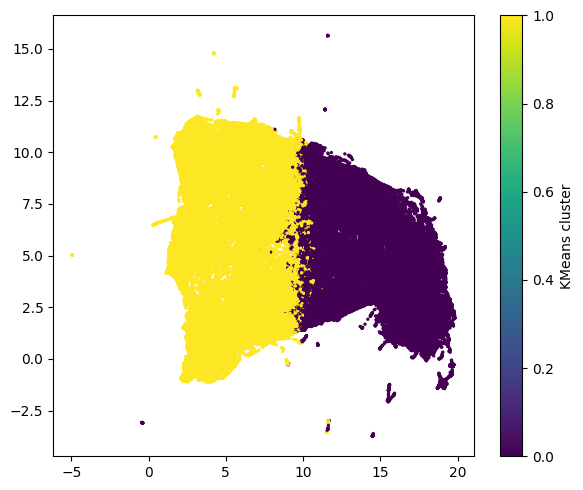

In [39]:
# 3) Fit KMeans (full set)
k = 2  # whatever you choose
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# (If memory is tight, swap to MiniBatchKMeans)
# kmeans = MiniBatchKMeans(n_clusters=k, batch_size=5000, random_state=42)
# labels = kmeans.fit_predict(X_scaled)

# 4) Attach to df
df["kmeans_full"] = labels

# 5) (Optional) visualize on your existing UMAP
plt.figure(figsize=(6,5))
sc = plt.scatter(df["umap1"], df["umap2"], c=df["kmeans_full"], s=2)
plt.colorbar(sc, label="KMeans cluster")
plt.tight_layout(); plt.show()

C:\Users\alber\AppData\Local\Temp\ipykernel_6752\2123814998.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n)



angle_head_res__head_int_deg stats:
     pair             U  p_raw  p_holm  reject
0  (0, 1)  1.731161e+09    0.0     0.0    True


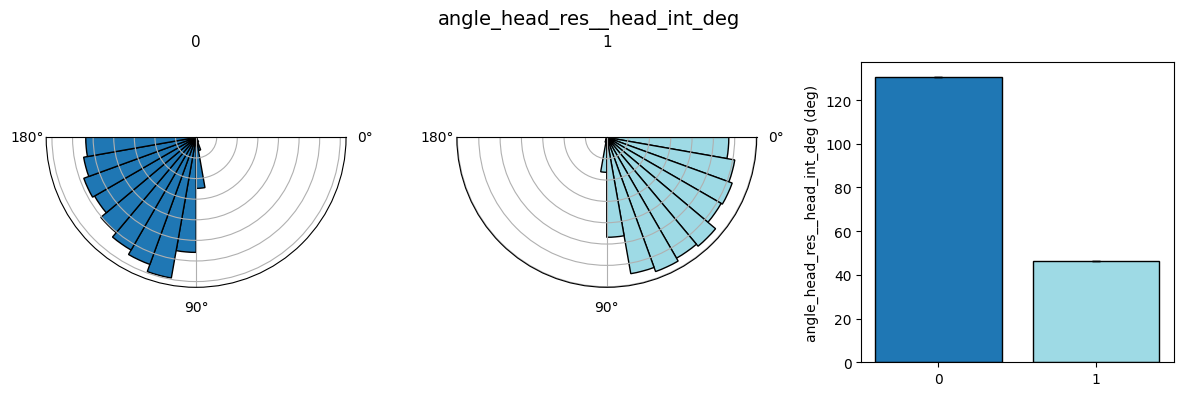


angle_head_res__hind_int_deg stats:
     pair             U  p_raw  p_holm  reject
0  (0, 1)  1.706468e+09    0.0     0.0    True


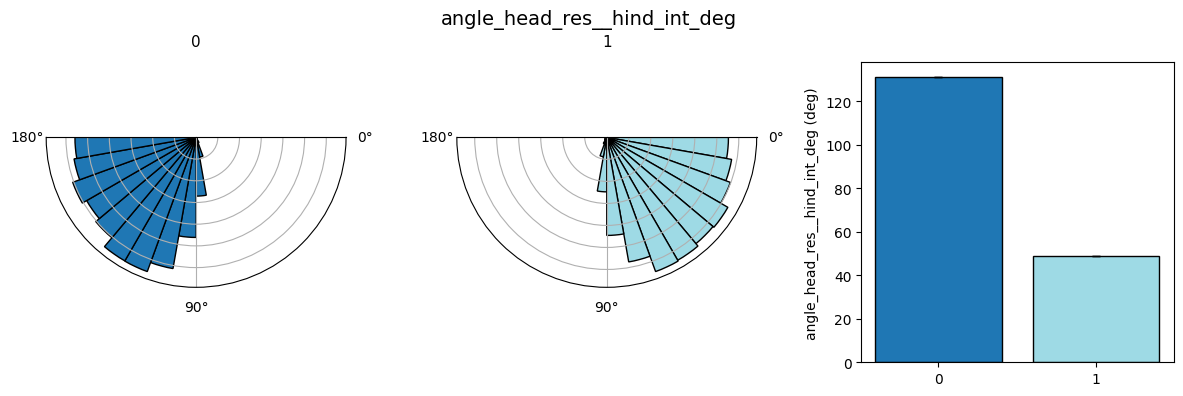


angle_head_int__hind_res_deg stats:
     pair             U  p_raw  p_holm  reject
0  (0, 1)  1.709569e+09    0.0     0.0    True


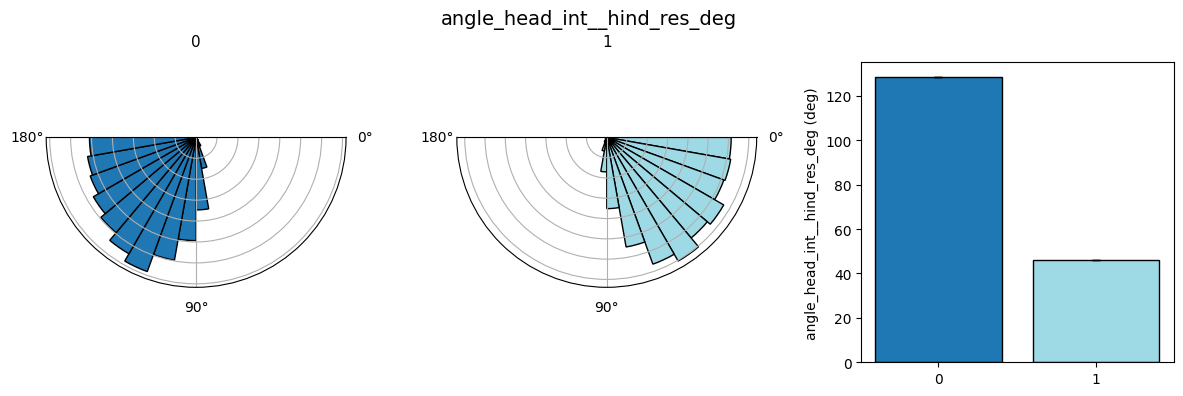


distance_head_res__head_int stats:
     pair            U  p_raw  p_holm  reject
0  (0, 1)  646878578.0    0.0     0.0    True


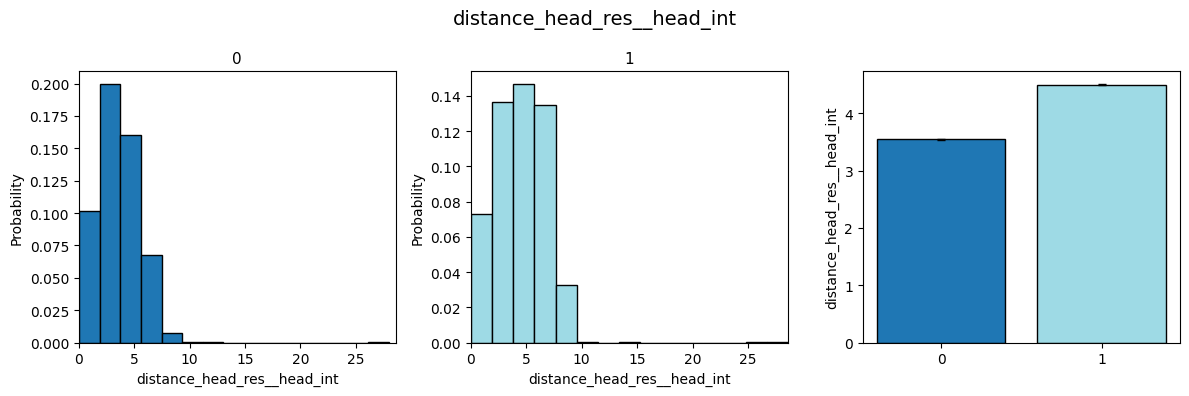


distance_head_res__hind_int stats:
     pair            U     p_raw    p_holm  reject
0  (0, 1)  875220472.0  0.535829  0.535829   False


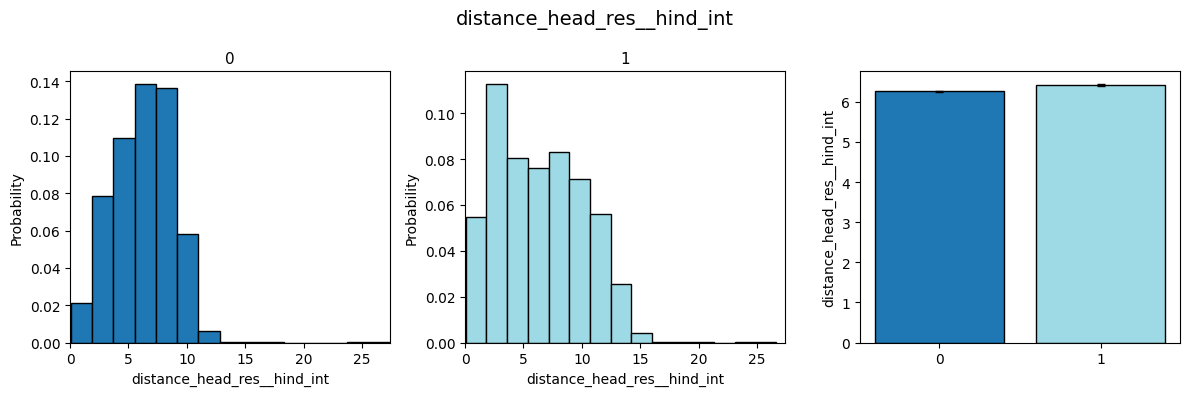


distance_head_int__hind_res stats:
     pair            U          p_raw         p_holm  reject
0  (0, 1)  793200480.0  6.086089e-116  6.086089e-116    True


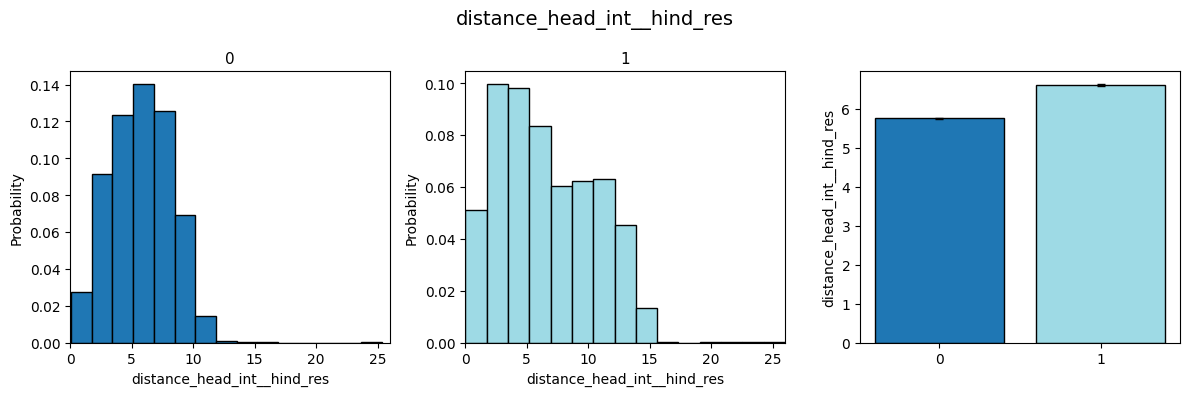


distance_hind_res__hind_int stats:
     pair             U  p_raw  p_holm  reject
0  (0, 1)  1.380398e+09    0.0     0.0    True


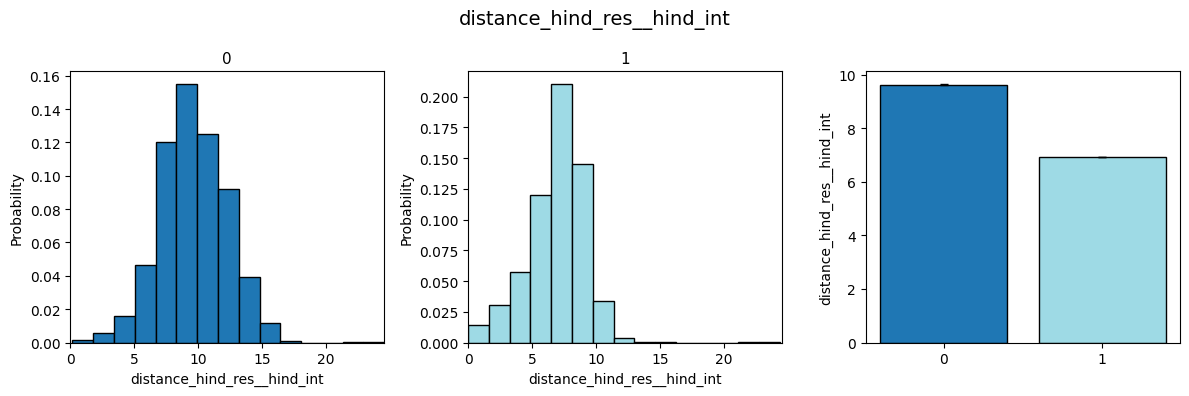


velocity_resident stats:
     pair            U  p_raw  p_holm  reject
0  (0, 1)  691543906.0    0.0     0.0    True


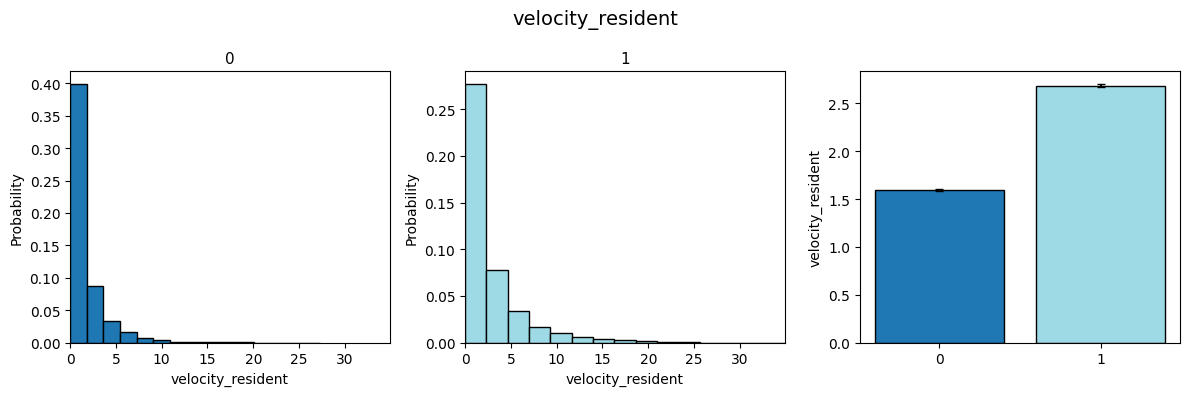


velocity_intruder stats:
     pair            U          p_raw         p_holm  reject
0  (0, 1)  794150525.5  3.020029e-113  3.020029e-113    True


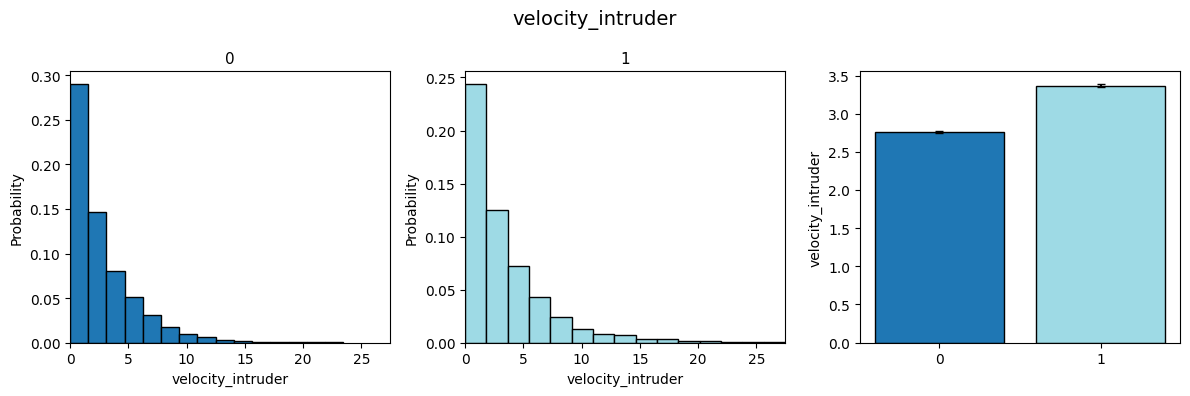

In [40]:
# ================== IMPORTS ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests

# ================== USER SETTINGS ==================
df = df  # <-- the table that already has UMAP + features + cluster labels
cluster_col = "kmeans_full"  # or whatever column holds your cluster IDs


angle_feats = [
    "angle_head_res__head_int_deg",
    "angle_head_res__hind_int_deg",
    "angle_head_int__hind_res_deg"
]

distance_feats = [
    "distance_head_res__head_int",
    "distance_head_res__hind_int",
    "distance_head_int__hind_res",
    "distance_hind_res__hind_int"
]

velocity_feats = [
    "velocity_resident",
    "velocity_intruder"
]

# Put all continuous (non-angle) features together if you want one loop:
linear_feats = distance_feats + velocity_feats

# ================== HELPERS ==================
def holm_pairwise(data, groups):
    """Return a dataframe of pairwise Mann–Whitney U tests with Holm correction.
       data: 1D numeric array
       groups: 1D labels of same length
    """
    levels = pd.unique(groups)
    pairs, pvals, stats = [], [], []
    for i in range(len(levels)):
        for j in range(i+1, len(levels)):
            g1, g2 = levels[i], levels[j]
            x1 = data[groups == g1]
            x2 = data[groups == g2]
            stat, p = mannwhitneyu(x1, x2, alternative="two-sided")
            pairs.append((g1, g2))
            pvals.append(p)
            stats.append(stat)
    reject, p_adj, _, _ = multipletests(pvals, method="holm")
    out = pd.DataFrame({
        "pair": pairs, "U": stats,
        "p_raw": pvals, "p_holm": p_adj, "reject": reject
    })
    return out


def polar_hist(ax, deg_values, bins=18, color="#69b3a2"):
    """Half-circle polar histogram 0-180° => 0-π rad."""
    rad = np.deg2rad(deg_values)
    hist, edges = np.histogram(rad, bins=bins, range=(0, np.pi), density=True)
    widths = np.diff(edges)
    ax.bar(edges[:-1], hist, width=widths,
           bottom=0, color=color, edgecolor="k", align="edge")
    ax.set_theta_zero_location("E")  # 0° at x+
    ax.set_theta_direction(-1)       # clockwise
    ax.set_thetalim(0, np.pi)
    ax.set_xticks([0, np.pi/2, np.pi])
    ax.set_xticklabels(["0°", "90°", "180°"])
    ax.set_yticklabels([])


def linear_hist(ax, values, bins=15, color="#69b3a2", xlabel="Value", xmax=None):
    ax.hist(values, bins=bins, density=True, color=color, edgecolor="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability")
    if xmax is not None:
        ax.set_xlim(0, xmax)


def bar_with_sem(ax, data, groups, colors=None, ylabel=""):
    g = pd.DataFrame({"v": data, "g": groups}).dropna()
    stats = g.groupby("g")["v"].agg(["mean","sem"])
    order = stats.index
    bars = ax.bar(np.arange(len(order)), stats["mean"], yerr=stats["sem"],
                  color=None if colors is None else [colors[o] for o in order],
                  edgecolor="k", capsize=3)
    ax.set_xticks(np.arange(len(order)))
    ax.set_xticklabels(order, rotation=0)
    ax.set_ylabel(ylabel)
    return stats


def nice_palette(n):
    cmap = plt.cm.get_cmap("tab20", n)
    return {i: cmap(i) for i in range(n)}

# ================== MASTER PLOTTER ==================
def plot_all_features(df, cluster_col,
                      angle_feats, linear_feats,
                      distance_feats=None, velocity_feats=None,
                      outdir=None):
    """
    Recreates the paper-style panels for every feature.
    Saves each feature as a figure if outdir is provided.
    """

    clusters = df[cluster_col].unique()
    clusters.sort()
    colors = nice_palette(len(clusters))

    # ---------- ANGLE FEATURES (polar + bar) ----------
    for feat in angle_feats:
        fig, axes = plt.subplots(1, len(clusters)+1, subplot_kw={"projection":"polar"},
                                 figsize=(4*(len(clusters)+1), 4))
        axes = np.atleast_1d(axes)

        # polar hists per cluster
        for i, cl in enumerate(clusters):
            vals = df.loc[df[cluster_col]==cl, feat].dropna().values
            polar_hist(axes[i], vals, color=colors[cl])
            axes[i].set_title(f"{cl}", pad=12, fontsize=11)

        # switch off polar for the last axis to do a bar plot
        axes[-1].remove()
        ax = fig.add_subplot(1, len(clusters)+1, len(clusters)+1)
        stats = bar_with_sem(ax,
                             df[feat].values,
                             df[cluster_col].values,
                             colors=colors,
                             ylabel=f"{feat} (deg)")
        # stats test
        pair_df = holm_pairwise(df[feat].values, df[cluster_col].values)
        print(f"\n{feat} stats:\n{pair_df}")

        fig.suptitle(feat, fontsize=14)
        fig.tight_layout()
        if outdir:
            fig.savefig(f"{outdir}/{feat}_angles.png", dpi=300)
        plt.show()

    # ---------- LINEAR FEATURES (hist + bar) ----------
    for feat in linear_feats:
        fig, axes = plt.subplots(1, len(clusters)+1, figsize=(4*(len(clusters)+1), 4))
        axes = np.atleast_1d(axes)

        # histograms
        xmax = df[feat].max()
        for i, cl in enumerate(clusters):
            vals = df.loc[df[cluster_col]==cl, feat].dropna().values
            linear_hist(axes[i], vals, bins=15, color=colors[cl],
                        xlabel=f"{feat}", xmax=xmax)
            axes[i].set_title(f"{cl}", fontsize=11)

        # bar plot
        stats = bar_with_sem(axes[-1],
                             df[feat].values,
                             df[cluster_col].values,
                             colors=colors,
                             ylabel=feat)
        pair_df = holm_pairwise(df[feat].values, df[cluster_col].values)
        print(f"\n{feat} stats:\n{pair_df}")

        fig.suptitle(feat, fontsize=14)
        fig.tight_layout()
        if outdir:
            fig.savefig(f"{outdir}/{feat}_linear.png", dpi=300)
        plt.show()


# ================== RUN IT ==================
plot_all_features(df,
                  cluster_col=cluster_col,
                  angle_feats=angle_feats,
                  linear_feats=linear_feats,
                  distance_feats=distance_feats,
                  velocity_feats=velocity_feats,
                  outdir=None)   # or a folder path to auto-save
